In [1]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512544 sha256=66869b280afdfb045af011d1ee856190ef6cd5186f1dcd772947e5c39af18dd8
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [2]:
import numpy as np 
import pandas as pd 
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import cv2
from scipy.signal import find_peaks
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import linear_sum_assignment
from moviepy.editor import VideoFileClip, AudioFileClip

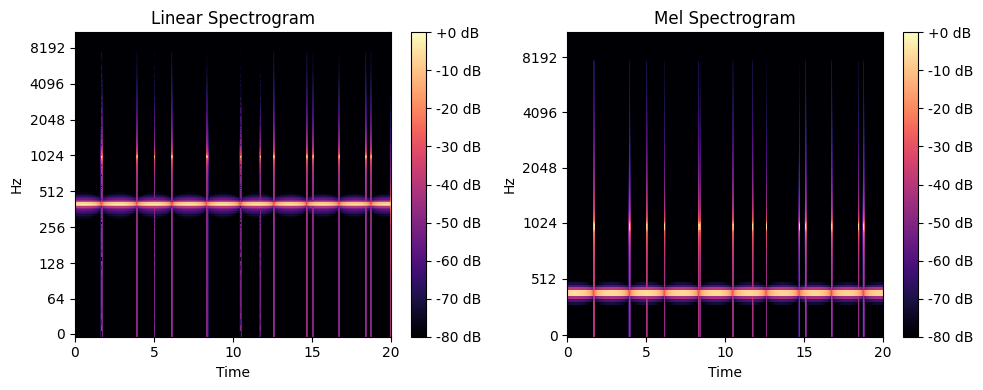

In [3]:
# Load audio file
audio_path = "/kaggle/input/search-for-a-match/dataset_Task2/audio_only/audio_only_ID_5.wav"
samples, sr = librosa.load(audio_path)

# Compute spectrogram
spec = np.abs(librosa.stft(samples))

# Compute mel-spectrogram
spec_mel = librosa.feature.melspectrogram(y=samples, sr=sr)

# Convert to decibels
spec_db = librosa.amplitude_to_db(spec, ref=np.max)
spec_mel_db = librosa.power_to_db(spec_mel, ref=np.max)

# Plot spectrogram
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(spec_db, y_axis='log', x_axis='time', sr=sr)
plt.title('Linear Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 2, 2)
librosa.display.specshow(spec_mel_db, y_axis='mel', x_axis='time', sr=sr)
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()


In [4]:
Audio(samples,rate=sr)

Timestamps of impulses: [ 0.          1.67053364  3.92111369  5.01160093  6.12529002  8.3062645
 10.46403712 11.71693735 12.57540603 14.66357309 15.05800464 16.70533643
 18.39907193 18.72389791]


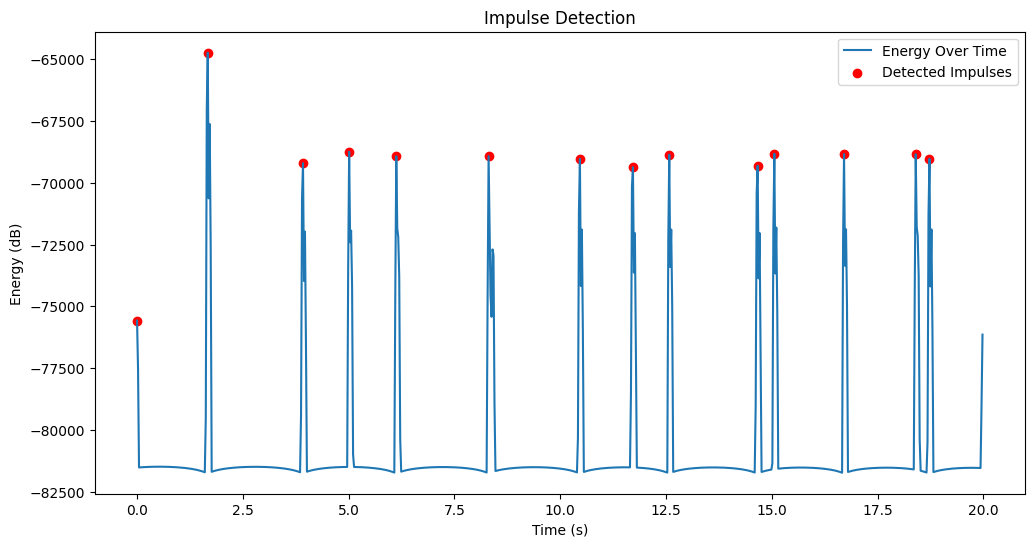

In [5]:
# Compute energy over time (sum across frequency bins)
energy_over_time = np.sum(spec_db, axis=0)

# Compute mean energy for thresholding
mean_energy = np.mean(energy_over_time)

# Create a binary mask for values above the mean energy
binary_mask = energy_over_time > mean_energy

# Initialize variables for peak detection
peaks = []
min_index = -1
prev = 0

# Loop through the binary mask to detect peaks
for i, val in enumerate(binary_mask):
    if val == 1 and prev == 0:  # Start of a peak
        min_index = i
    elif val == 0 and prev == 1:  # End of a peak
        max_index = i - 1
        # Find the exact index of the maximum within this range
        peak_index = np.argmax(energy_over_time[min_index:max_index + 1]) + min_index
        peaks.append(peak_index)  # Store the exact peak index
    prev = val

# Convert detected indices to timestamps (time in seconds)
timestamps = np.array(peaks) * (20 / spec_db.shape[1])

print("Timestamps of impulses:", timestamps)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(energy_over_time)) * (20 / spec_db.shape[1]), energy_over_time, label="Energy Over Time")
plt.scatter(timestamps, energy_over_time[np.array(peaks)], color='red', label='Detected Impulses')
plt.xlabel("Time (s)")
plt.ylabel("Energy (dB)")
plt.title("Impulse Detection")
plt.legend()
plt.show()


In [6]:
def get_impulse_times(audio_file_path):
    samples,sr = librosa.load(audio_file_path)
    time = samples.size/sr
    # Compute spectrogram
    spec = np.abs(librosa.stft(samples))
    
    # Convert to decibels
    spec_db = librosa.amplitude_to_db(spec, ref=np.max)
    
    # Compute energy over time (sum across frequency bins)
    energy_over_time = np.sum(spec_db, axis=0)
    
    # Compute mean energy for thresholding
    mean_energy = np.mean(energy_over_time)
    
    # Create a binary mask for values above the mean energy
    binary_mask = energy_over_time > mean_energy
    
    # Initialize variables for peak detection
    peaks = []
    min_index = -1
    prev = 0

    # Loop through the binary mask to detect peaks
    for i, val in enumerate(binary_mask):
        if val == 1 and prev == 0:  # Start of a peak
            min_index = i
        elif val == 0 and prev == 1:  # End of a peak
            max_index = i - 1
            # Find the exact index of the maximum within this range
            peak_index = np.argmax(energy_over_time[min_index:max_index + 1]) + min_index
            peaks.append(peak_index)  # Store the exact peak index
        prev = val

    # Convert detected indices to timestamps (time in seconds)
    timestamps = np.array(peaks) * (time / spec_db.shape[1])

    return timestamps

In [7]:
times = get_impulse_times("/kaggle/input/search-for-a-match/dataset_Task2/audio_only/audio_only_ID_10.wav")
print(times)

[ 0.          0.51044084  1.55452436  2.4361949   2.57540603  3.61948956
  4.64037123  5.26682135  5.68445476  6.70533643  7.74941995  8.05104408
  8.77030162  9.81438515 10.83526682 11.87935035 12.90023202 13.54988399
 13.94431555 14.96519722 16.00928074 16.26450116 17.03016241 18.07424594
 18.90951276 19.09512761]


In [8]:
samples,sr = librosa.load("/kaggle/input/search-for-a-match/dataset_Task2/audio_only/audio_only_ID_10.wav")
Audio(samples,rate=sr)

In [9]:
video = cv2.VideoCapture("/kaggle/input/search-for-a-match/dataset_Task2/video_only/video_only_ID_14.mp4")
fps = video.get(cv2.CAP_PROP_FPS)

In [10]:
ret, frame = video.read()

In [11]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 100, 150)

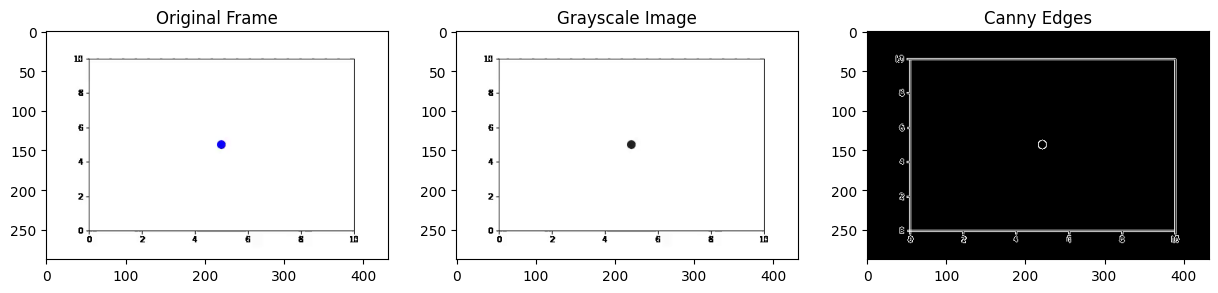

In [12]:
# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Frame")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Grayscale Image")
plt.imshow(gray, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Canny Edges")
plt.imshow(edges, cmap='gray')

plt.show()

Positions of highest peaks: [ 53  55 388 390]


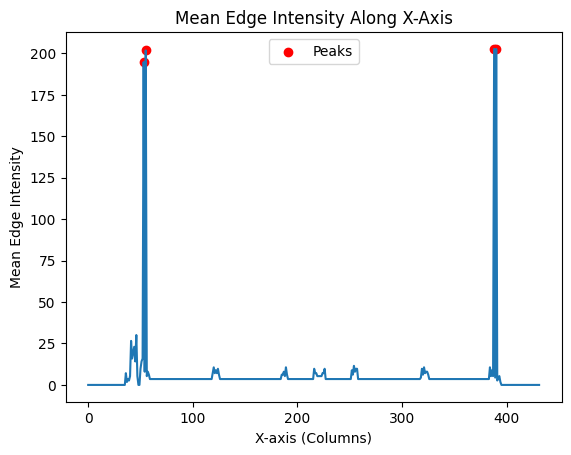

In [13]:
mean_along_xaxis = np.mean(edges,axis=0)
# Find peaks
peaks_x, _ = find_peaks(mean_along_xaxis, height=150)  # Adjust height threshold as needed

# Display peak positions
print("Positions of highest peaks:", peaks_x)

# Plot the graph with peaks highlighted
plt.plot(mean_along_xaxis)
plt.scatter(peaks_x, mean_along_xaxis[peaks_x], color='red', label='Peaks')
plt.title("Mean Edge Intensity Along X-Axis")
plt.xlabel("X-axis (Columns)")
plt.ylabel("Mean Edge Intensity")
plt.legend()
plt.show()

Positions of highest peaks: [ 34  36 251 253]


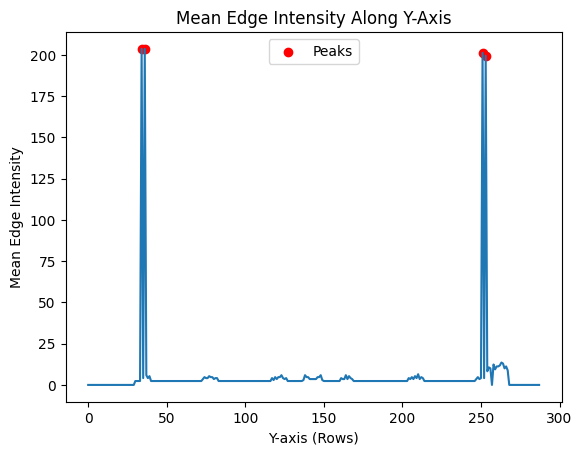

In [14]:
mean_along_yaxis = np.mean(edges,axis=1)
# Find peaks
peaks_y, _ = find_peaks(mean_along_yaxis, height=150)  # Adjust height threshold as needed

# Display peak positions
print("Positions of highest peaks:", peaks_y)

# Plot the graph with peaks highlighted
plt.plot(mean_along_yaxis)
plt.scatter(peaks_y, mean_along_yaxis[peaks_y], color='red', label='Peaks')
plt.title("Mean Edge Intensity Along Y-Axis")
plt.xlabel("Y-axis (Rows)")
plt.ylabel("Mean Edge Intensity")
plt.legend()
plt.show()

In [15]:
twoPeaks_x = []
twoPeaks_x.append(int((peaks_x[0]+peaks_x[1])/2))
twoPeaks_x.append(int((peaks_x[2]+peaks_x[3])/2))
twoPeaks_y = []
twoPeaks_y.append(int((peaks_y[0]+peaks_y[1])/2))
twoPeaks_y.append(int((peaks_y[2]+peaks_y[3])/2))

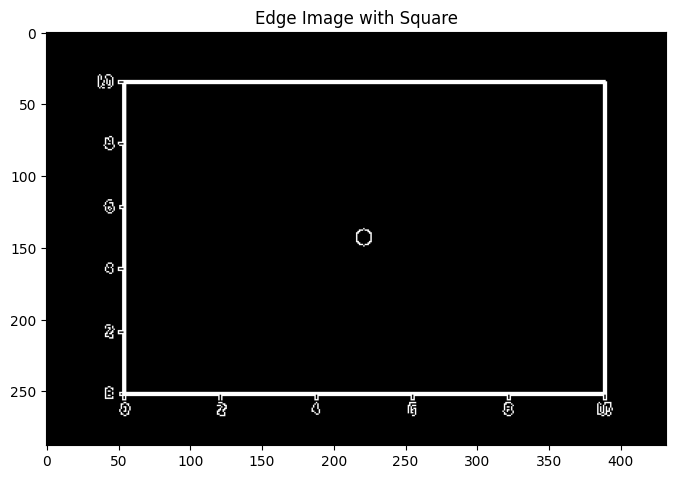

In [16]:
# Draw a square using the two peak positions
top_left = (twoPeaks_x[0], twoPeaks_y[0])
bottom_right = (twoPeaks_x[1], twoPeaks_y[1])

# Draw the square on the edge image
cv2.rectangle(edges, top_left, bottom_right, (255, 255, 255), thickness=1)

# Visualize the edge image with the square
plt.figure(figsize=(8, 6))
plt.title("Edge Image with Square")
plt.imshow(edges, cmap='gray')
plt.show()

In [ ]:
def detect_peaks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 150)
    
    # Mean edge intensity along x-axis
    mean_along_xaxis = np.mean(edges, axis=0)
    peaks_x, _ = find_peaks(mean_along_xaxis, height=150)  # Adjust height threshold as needed
    
    # Mean edge intensity along y-axis
    mean_along_yaxis = np.mean(edges, axis=1)
    peaks_y, _ = find_peaks(mean_along_yaxis, height=150)  # Adjust height threshold as needed
    
    return peaks_x, peaks_y

def check_peaks_length(video_files):
    results = {}
    
    for video_file in video_files:
        #print(f"Processing {video_file}...")
        cap = cv2.VideoCapture(video_file)
        ret, frame = cap.read()
        
        if not ret:
            print(f"Error: Unable to read video {video_file}")
            results[video_file] = "Error reading video"
            continue
        
        # Detect peaks
        peaks_x, peaks_y = detect_peaks(frame)
        
        # Check lengths
        results[video_file] = {
            "peaks_x_length": len(peaks_x),
            "peaks_y_length": len(peaks_y),
            "valid": len(peaks_x) == 4 and len(peaks_y) == 4
        }
        
        cap.release()
    
    return results

# List of video files (replace this with the actual file paths)
video_folder = "/kaggle/input/search-for-a-match/dataset_Task2/video_only"  # Replace with your folder path
video_files = [os.path.join(video_folder, f) for f in os.listdir(video_folder) if f.endswith(".mp4")]

# Check peaks length for all videos
results = check_peaks_length(video_files)

# Print results
for video_file, result in results.items():
    print(f"{video_file}: {result}")


/kaggle/input/search-for-a-match/dataset_Task2/video_only/video_only_ID_32.mp4: {'peaks_x_length': 4, 'peaks_y_length': 4, 'valid': True}
/kaggle/input/search-for-a-match/dataset_Task2/video_only/video_only_ID_6.mp4: {'peaks_x_length': 4, 'peaks_y_length': 4, 'valid': True}
/kaggle/input/search-for-a-match/dataset_Task2/video_only/video_only_ID_25.mp4: {'peaks_x_length': 4, 'peaks_y_length': 4, 'valid': True}
/kaggle/input/search-for-a-match/dataset_Task2/video_only/video_only_ID_42.mp4: {'peaks_x_length': 4, 'peaks_y_length': 4, 'valid': True}
/kaggle/input/search-for-a-match/dataset_Task2/video_only/video_only_ID_7.mp4: {'peaks_x_length': 4, 'peaks_y_length': 4, 'valid': True}
/kaggle/input/search-for-a-match/dataset_Task2/video_only/video_only_ID_40.mp4: {'peaks_x_length': 4, 'peaks_y_length': 4, 'valid': True}
/kaggle/input/search-for-a-match/dataset_Task2/video_only/video_only_ID_15.mp4: {'peaks_x_length': 4, 'peaks_y_length': 4, 'valid': True}
/kaggle/input/search-for-a-match/dat

In [18]:
def detect_coordinates(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 150)
    
    mean_along_xaxis = np.mean(edges,axis=0)
    # Find peaks
    peaks_x, _ = find_peaks(mean_along_xaxis, height=150)  # Adjust height threshold as needed
    twoPeaks_x = []
    twoPeaks_x.append(int((peaks_x[0]+peaks_x[1])/2))
    twoPeaks_x.append(int((peaks_x[2]+peaks_x[3])/2))

    mean_along_yaxis = np.mean(edges,axis=1)
    peaks_y, _ = find_peaks(mean_along_yaxis, height=150)  # Adjust height threshold as needed
    twoPeaks_y = []
    twoPeaks_y.append(int((peaks_y[0]+peaks_y[1])/2))
    twoPeaks_y.append(int((peaks_y[2]+peaks_y[3])/2))

    return (twoPeaks_x[0],twoPeaks_y[0],twoPeaks_x[1],twoPeaks_y[1])


Collision at 1.30 seconds


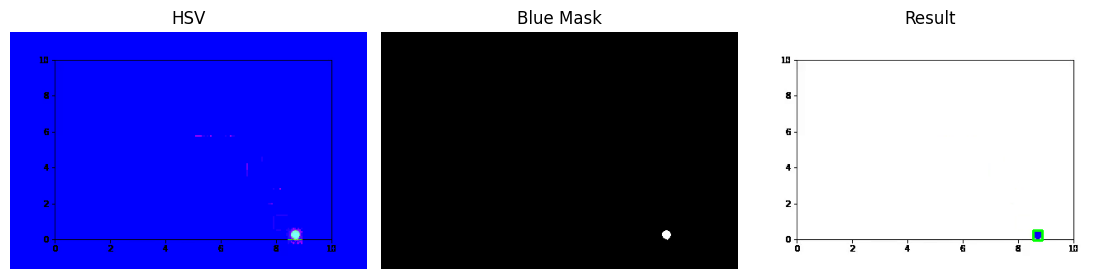

Collision at 1.32 seconds


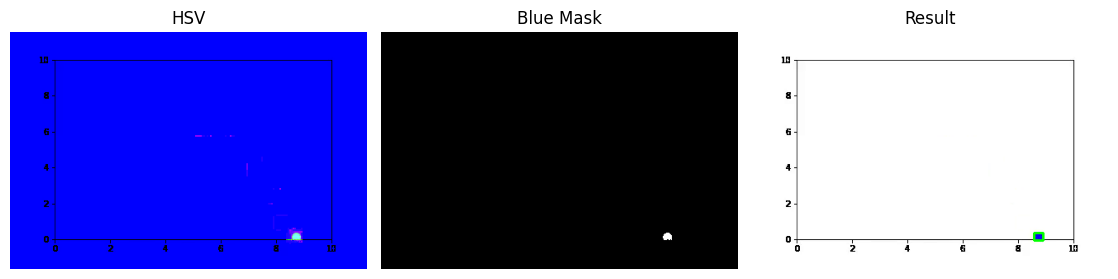

Collision at 1.33 seconds


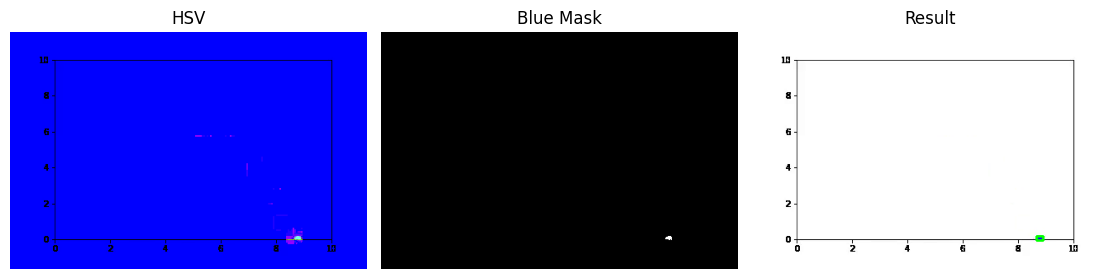

Collision at 1.35 seconds


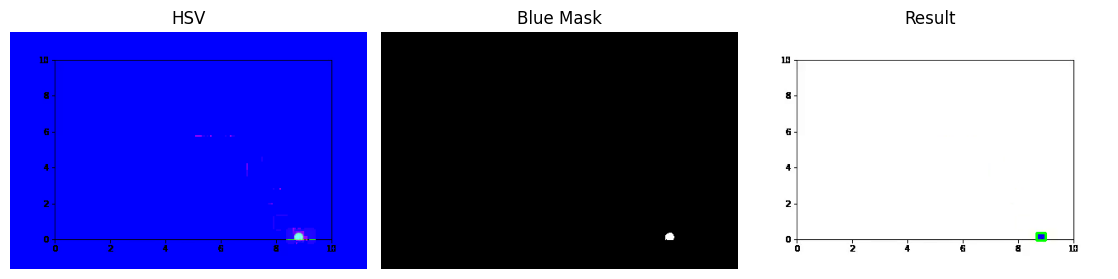

Collision at 1.37 seconds


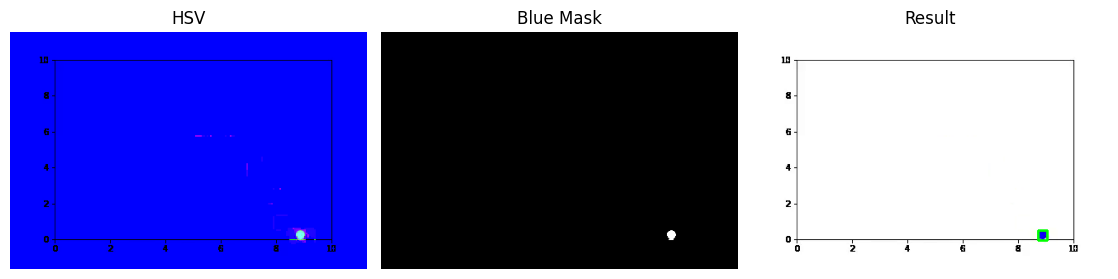

Collision at 1.72 seconds


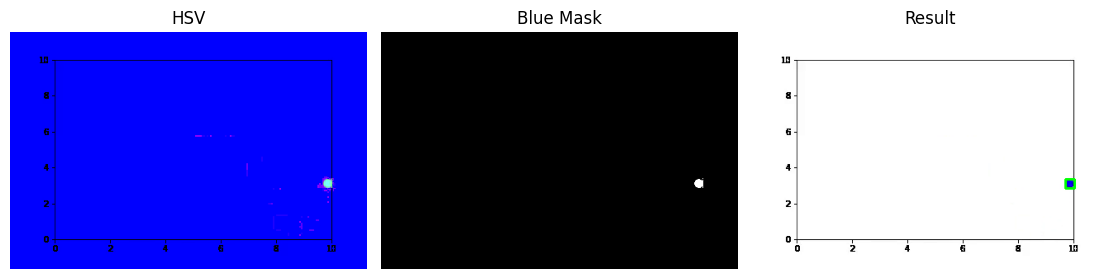

Collision at 1.73 seconds


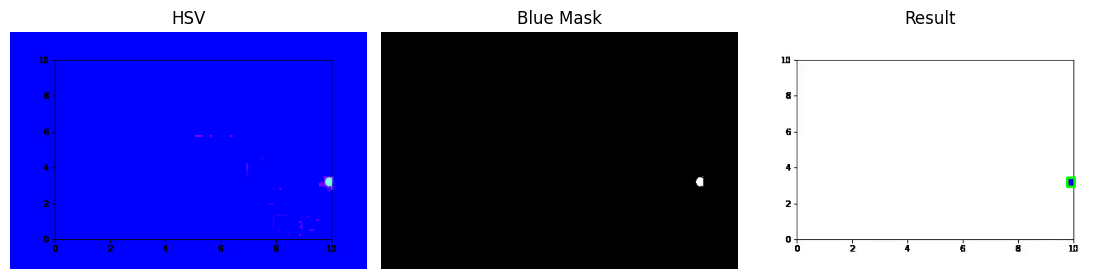

Collision at 1.75 seconds


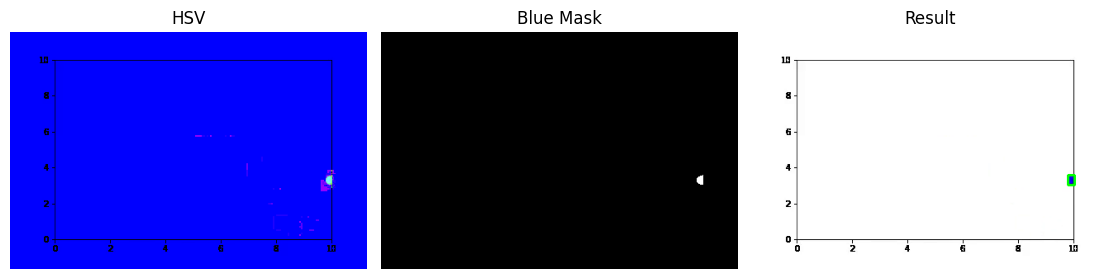

Collision at 1.77 seconds


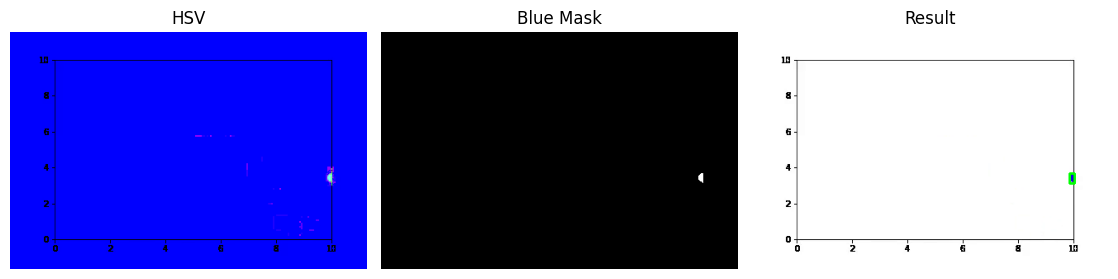

Collision at 1.78 seconds


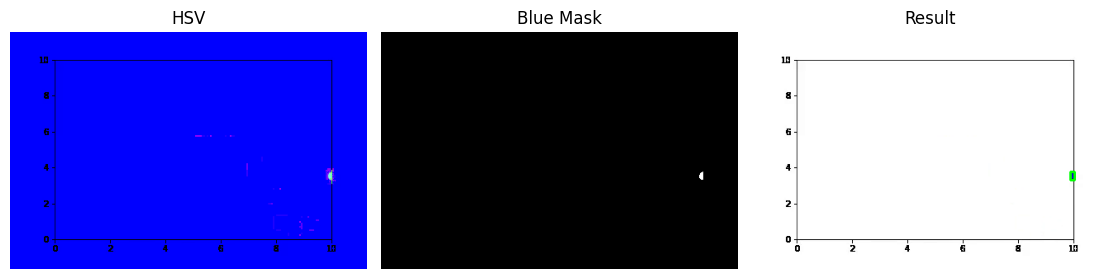

Collision at 1.80 seconds


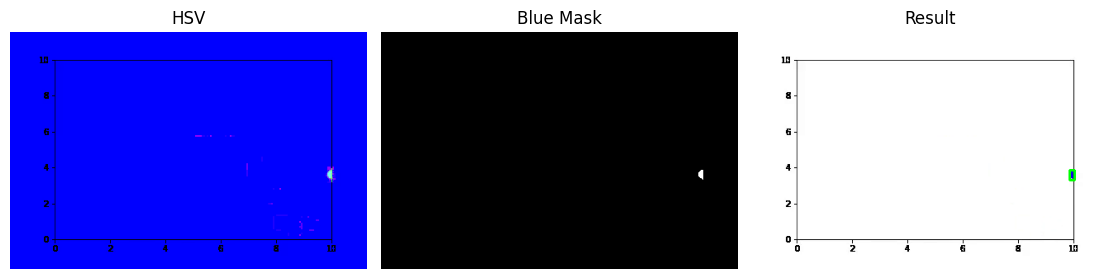

Collision at 1.82 seconds


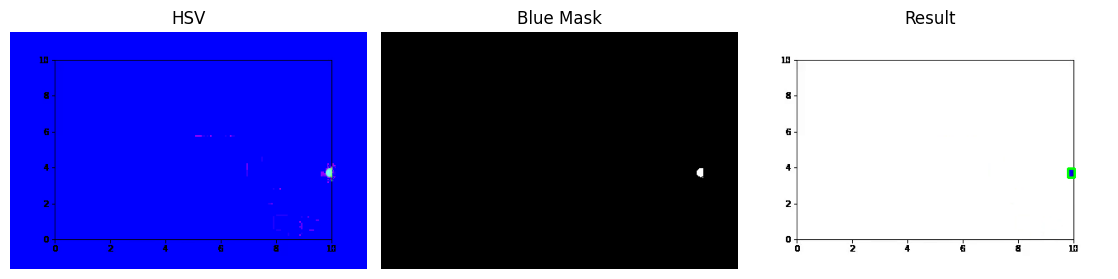

Collision at 1.83 seconds


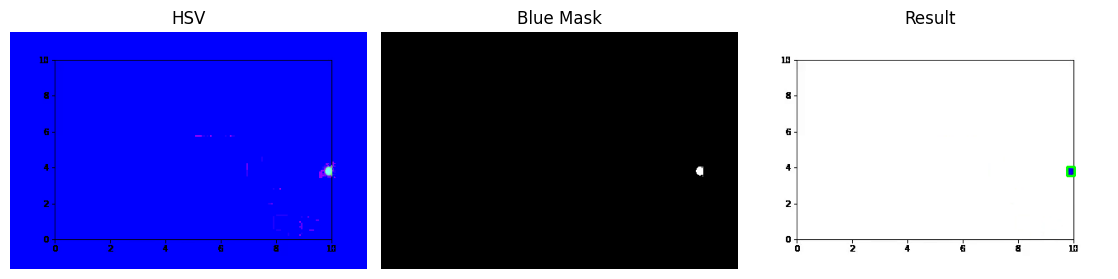

Collision at 1.85 seconds


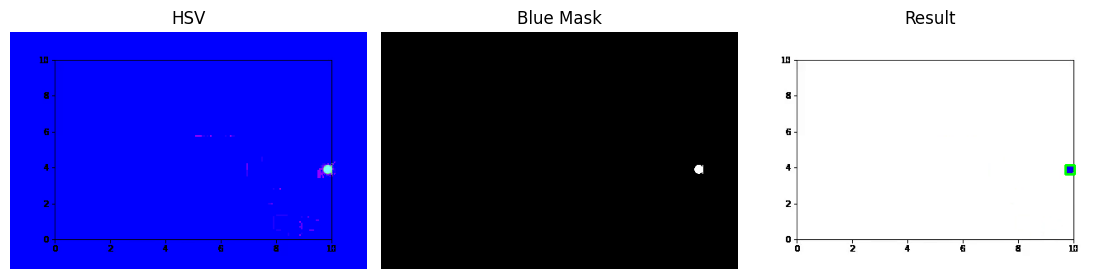

Collision at 3.38 seconds


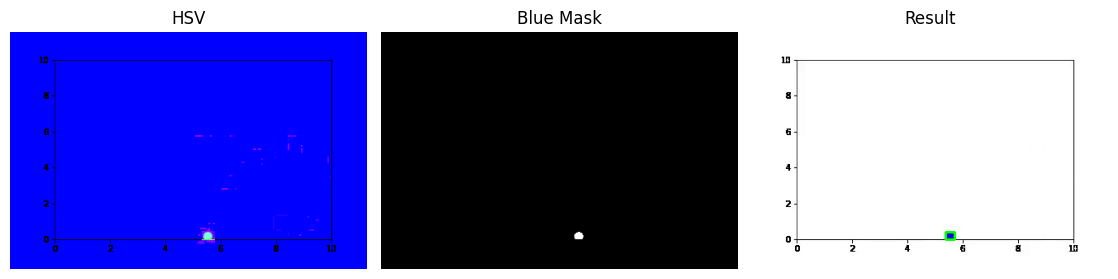

Collision at 3.40 seconds


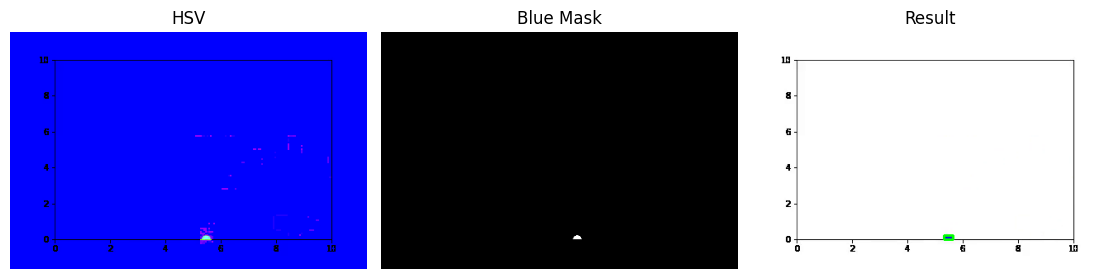

Collision at 3.43 seconds


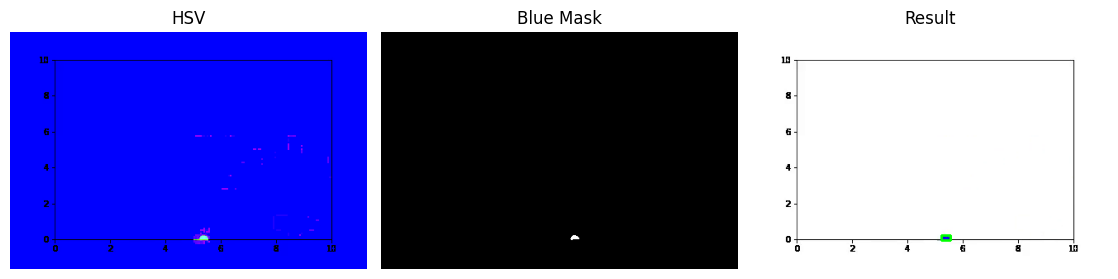

Collision at 3.45 seconds


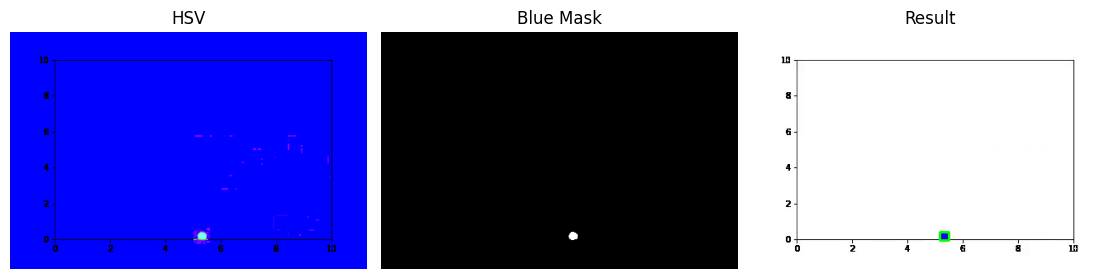

Collision at 5.27 seconds


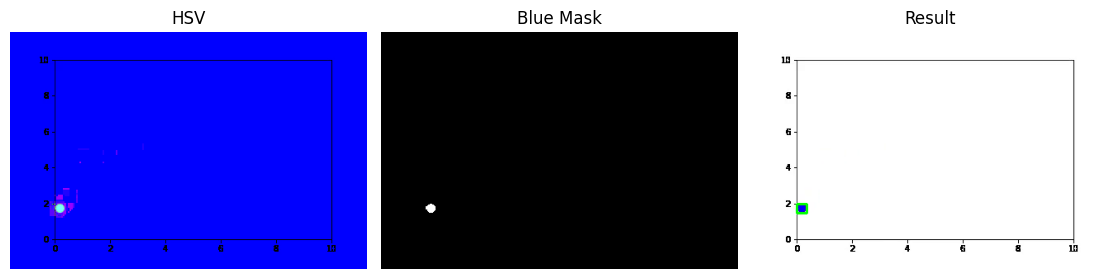

Collision at 5.28 seconds


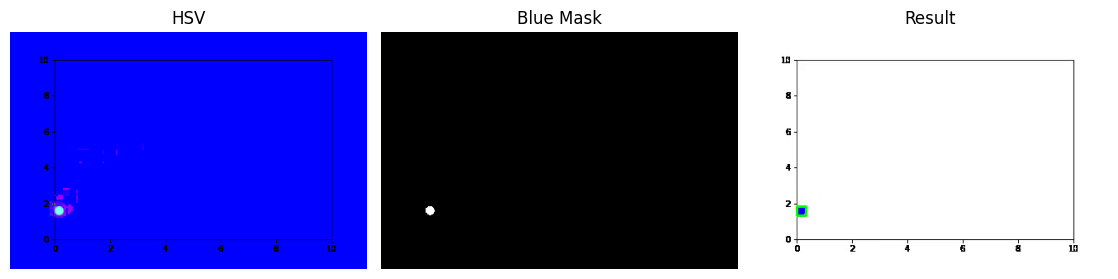

Collision at 5.30 seconds


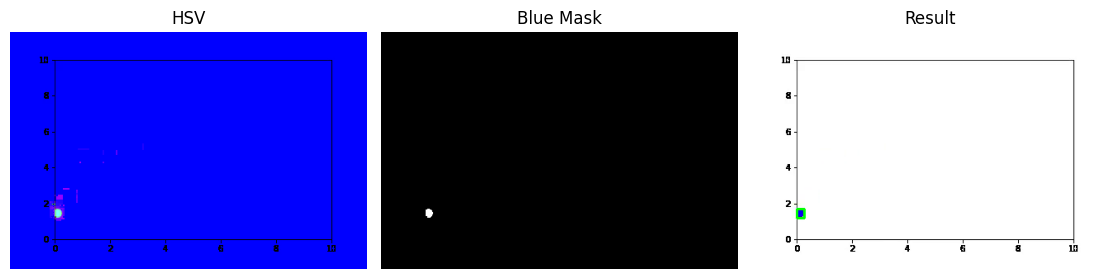

Collision at 5.32 seconds


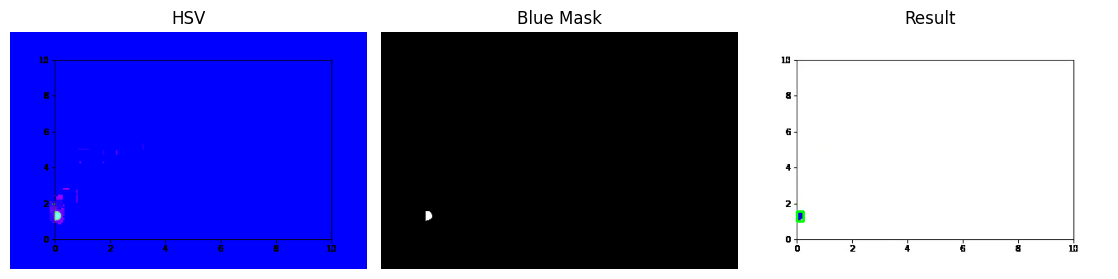

Collision at 5.33 seconds


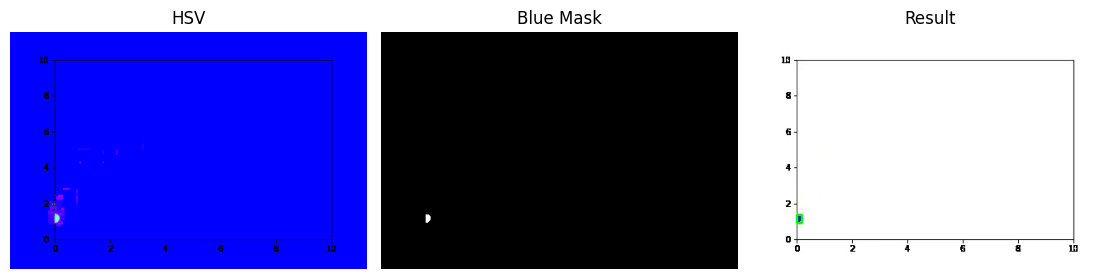

Collision at 5.35 seconds


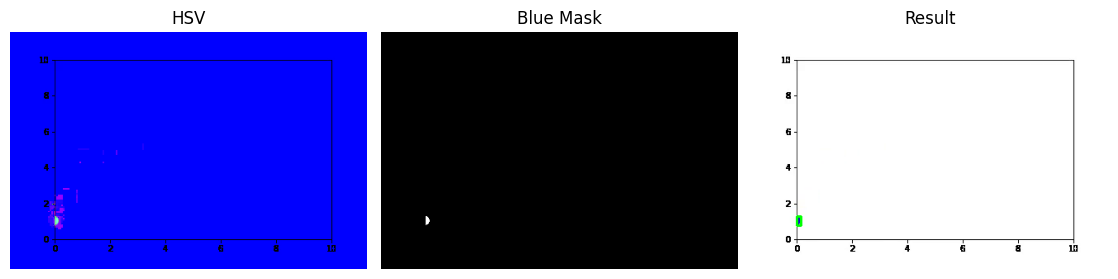

Collision at 5.37 seconds


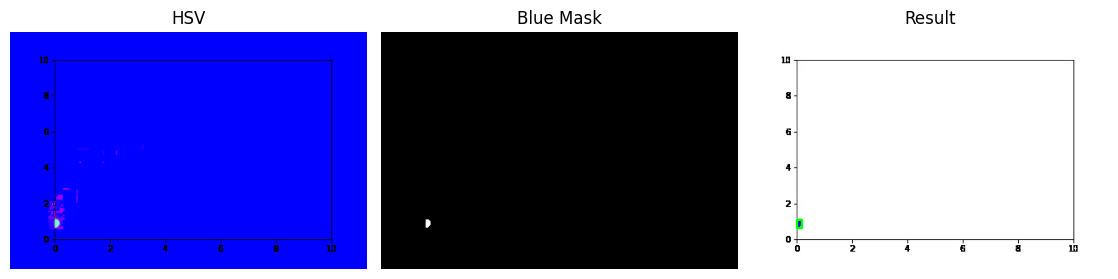

Collision at 5.38 seconds


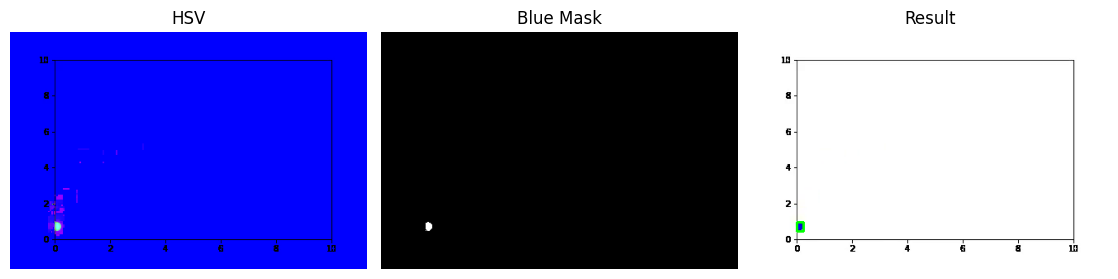

Collision at 5.40 seconds


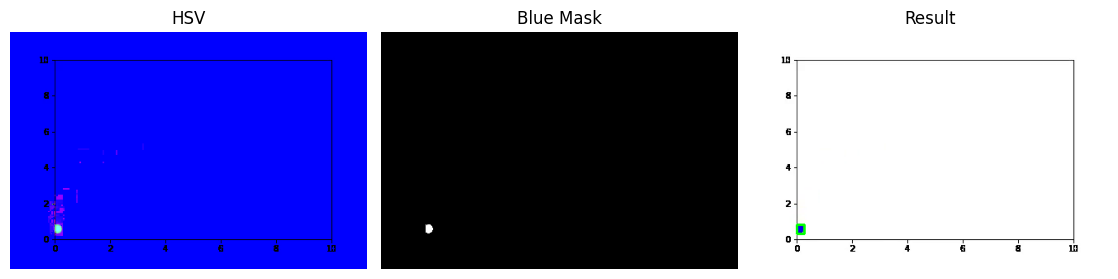

Collision at 5.42 seconds


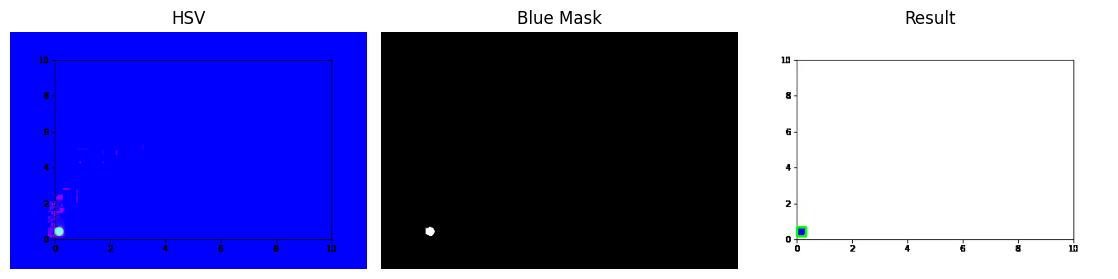

Collision at 5.43 seconds


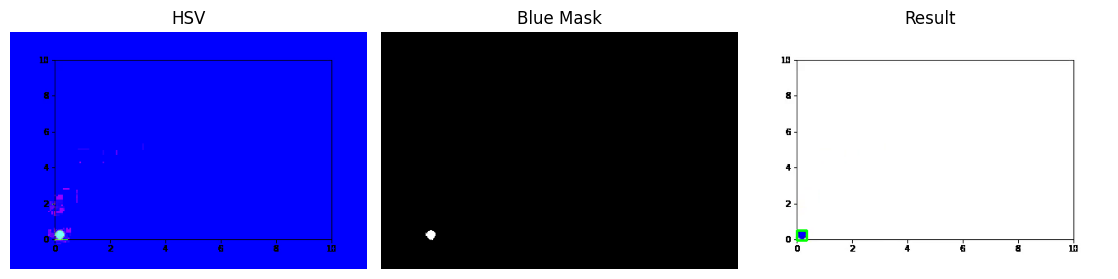

Collision at 5.45 seconds


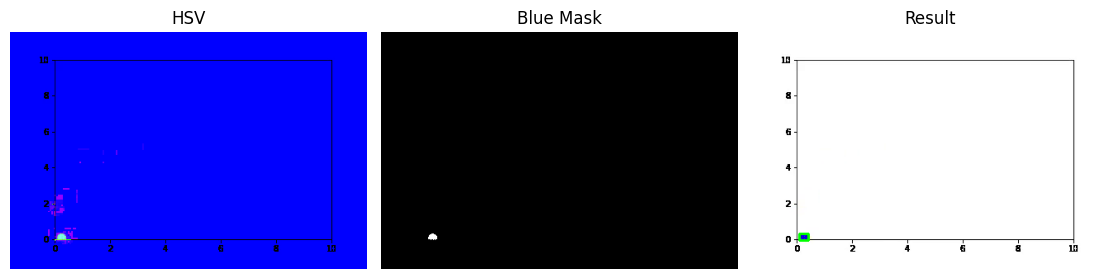

Collision at 5.47 seconds


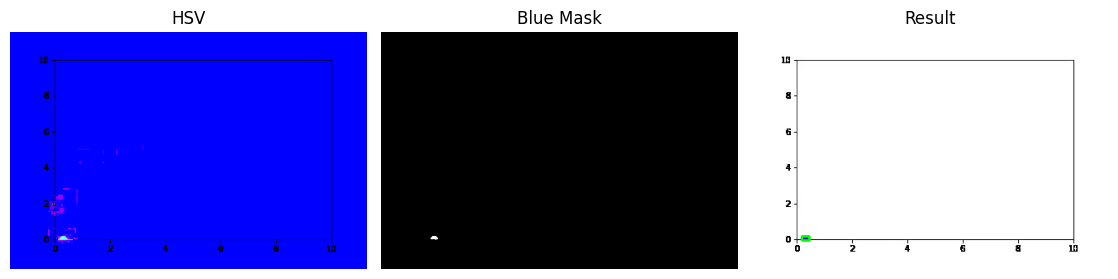

Collision at 5.48 seconds


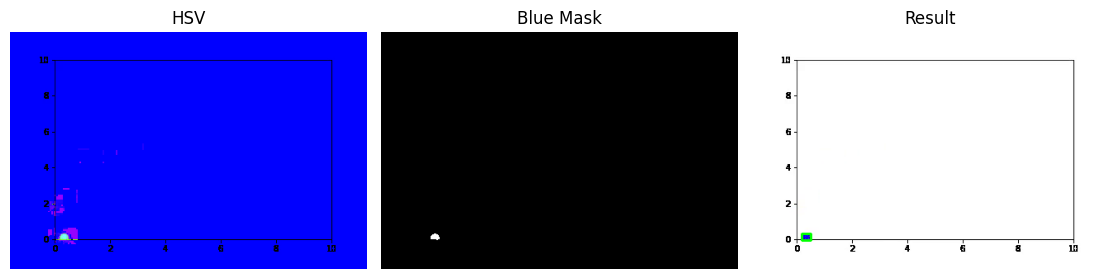

Collision at 5.50 seconds


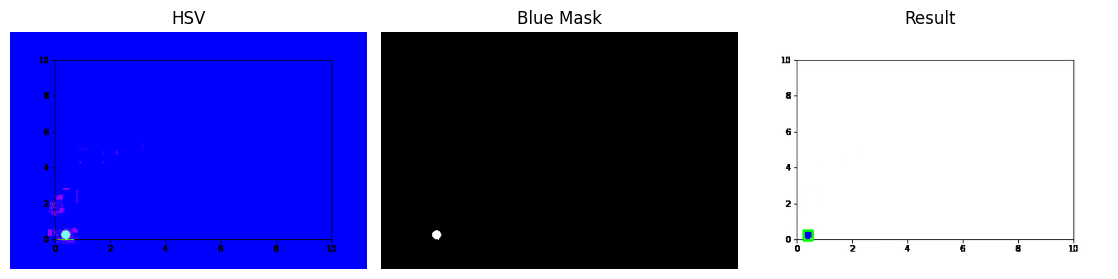

Collision at 7.45 seconds


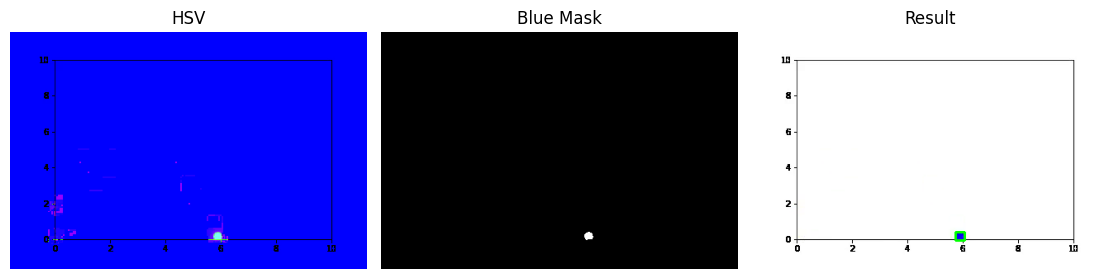

Collision at 7.47 seconds


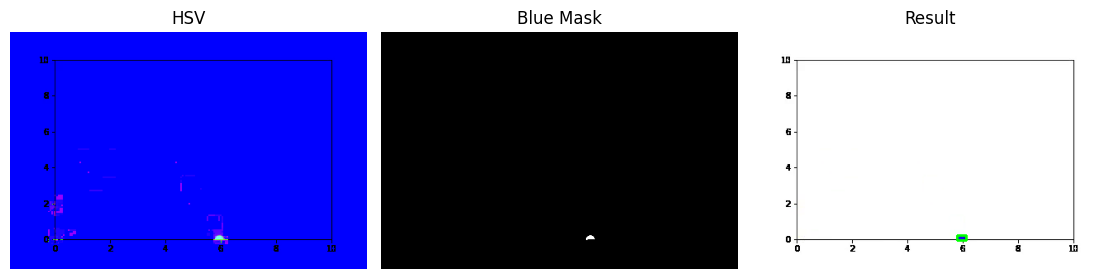

Collision at 7.50 seconds


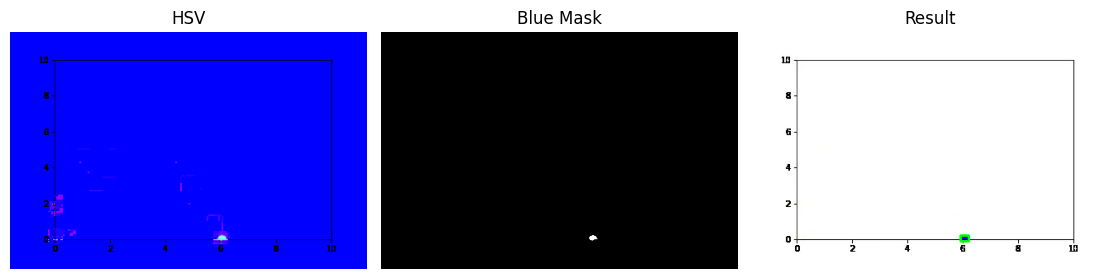

Collision at 7.52 seconds


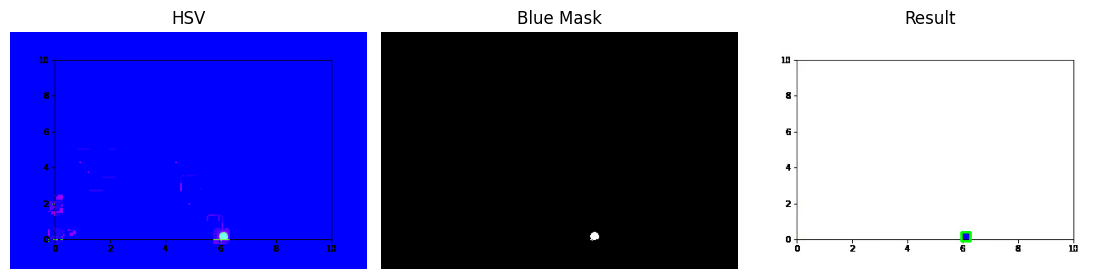

Collision at 8.85 seconds


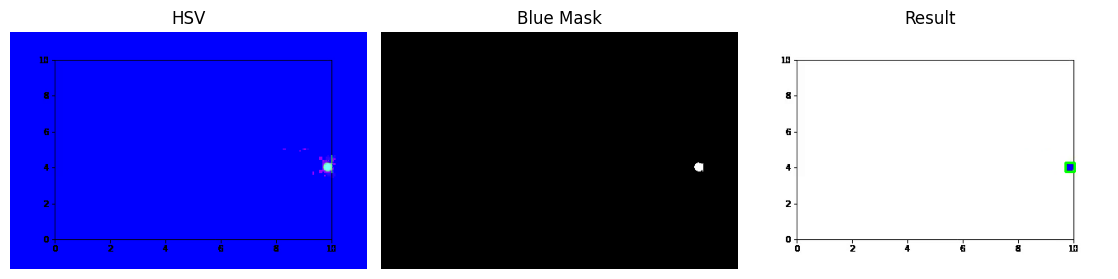

Collision at 8.87 seconds


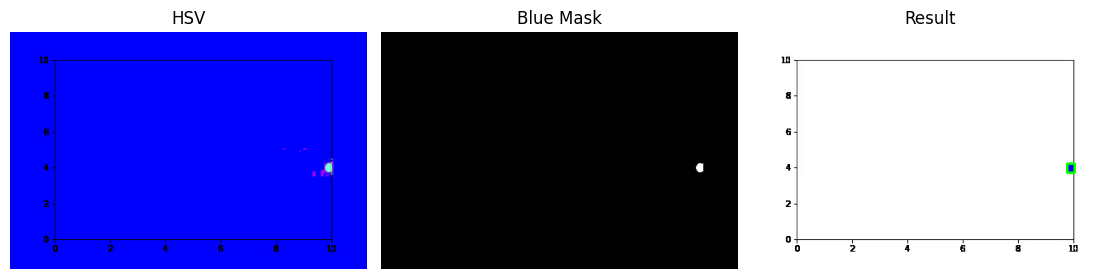

Collision at 8.88 seconds


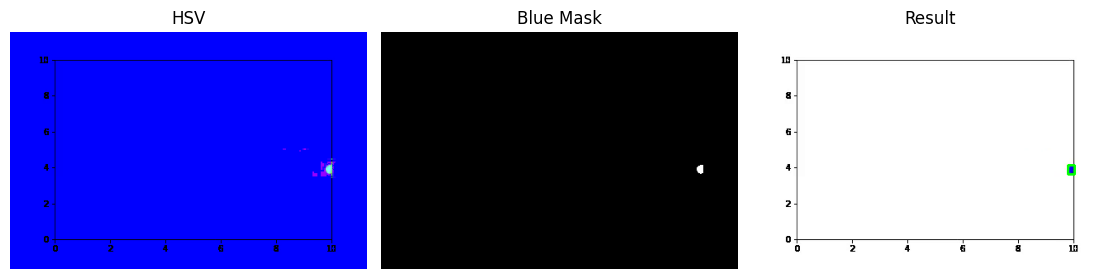

Collision at 8.90 seconds


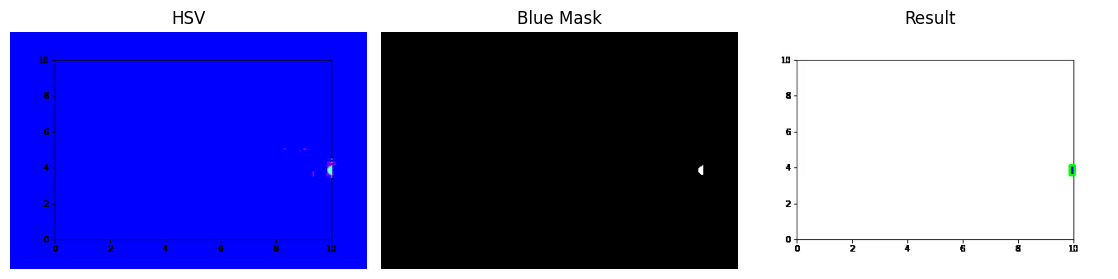

Collision at 8.92 seconds


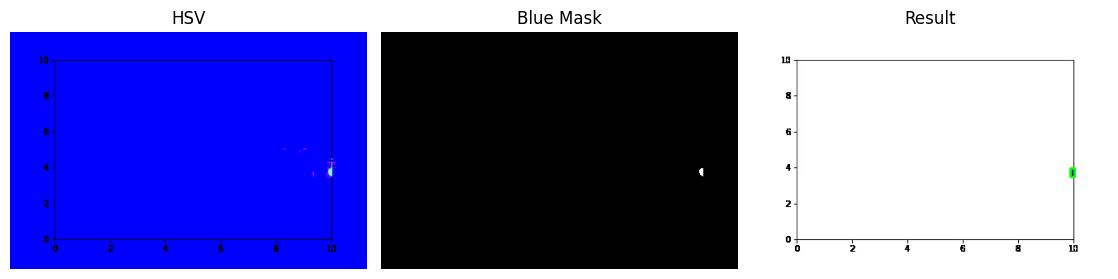

Collision at 8.93 seconds


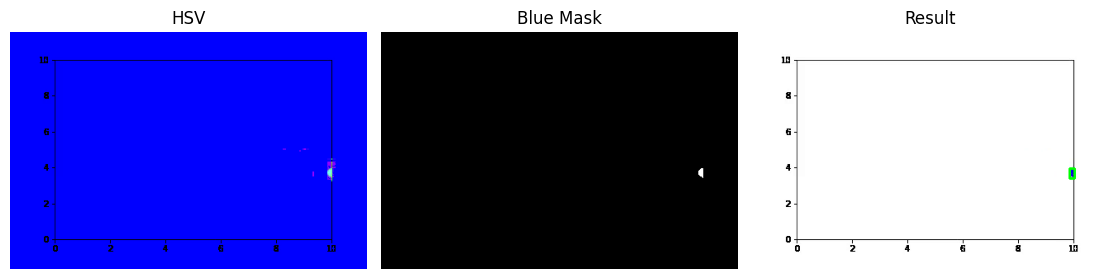

Collision at 8.95 seconds


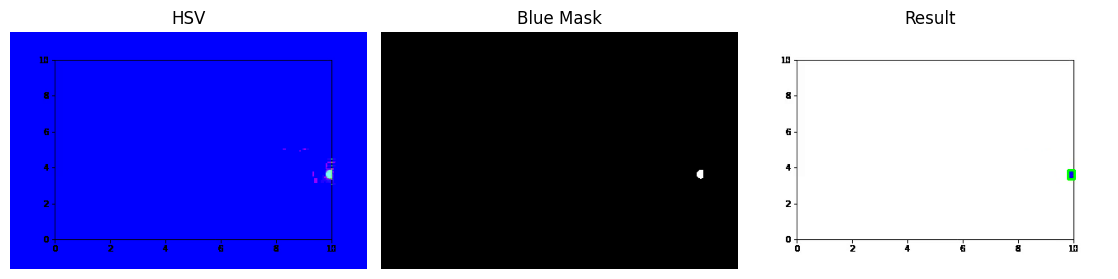

Collision at 8.97 seconds


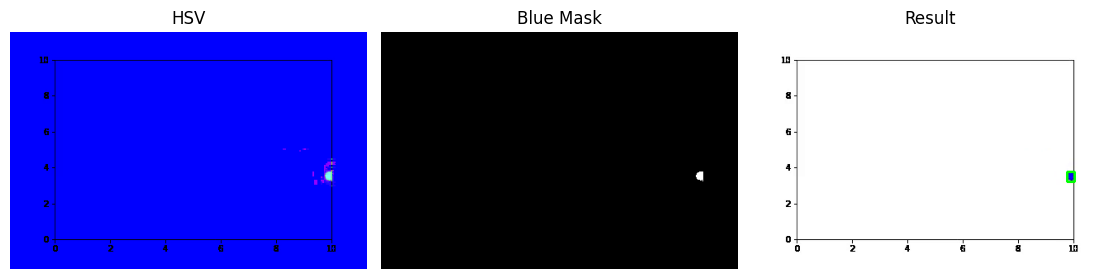

Collision at 8.98 seconds


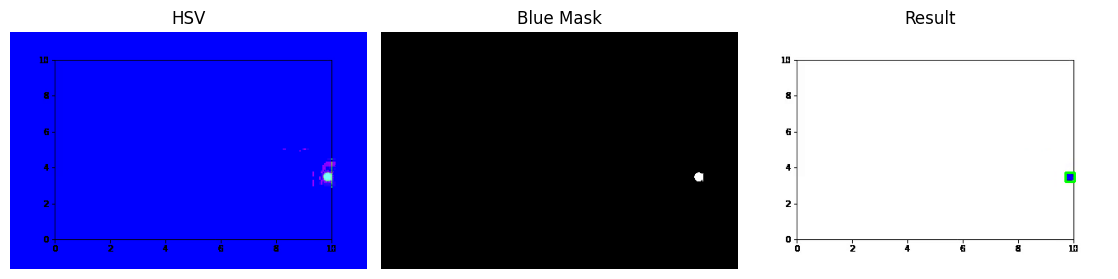

Collision at 9.43 seconds


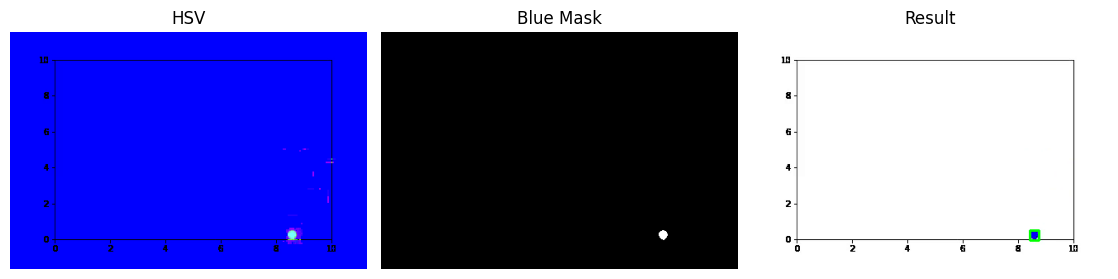

Collision at 9.45 seconds


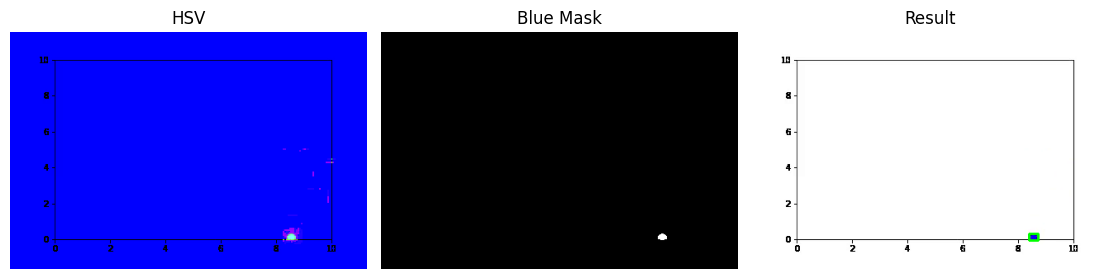

Collision at 9.47 seconds


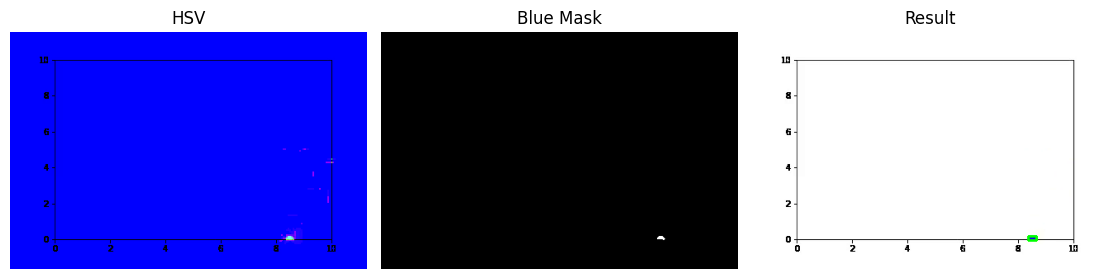

Collision at 9.48 seconds


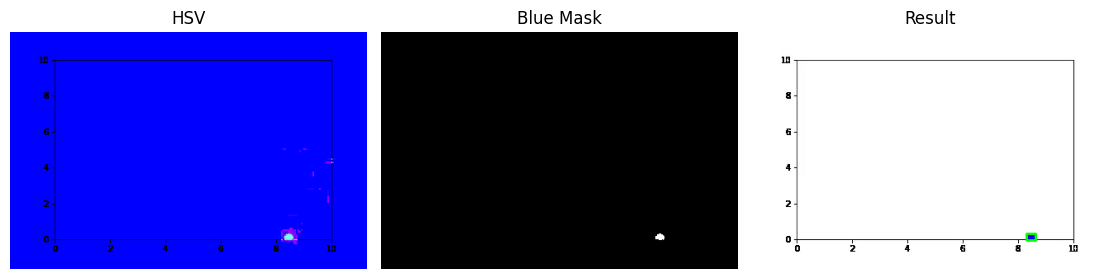

Collision at 9.50 seconds


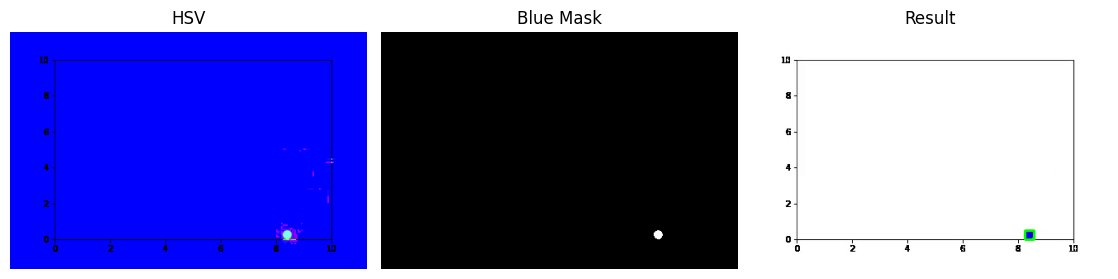

Collision at 11.38 seconds


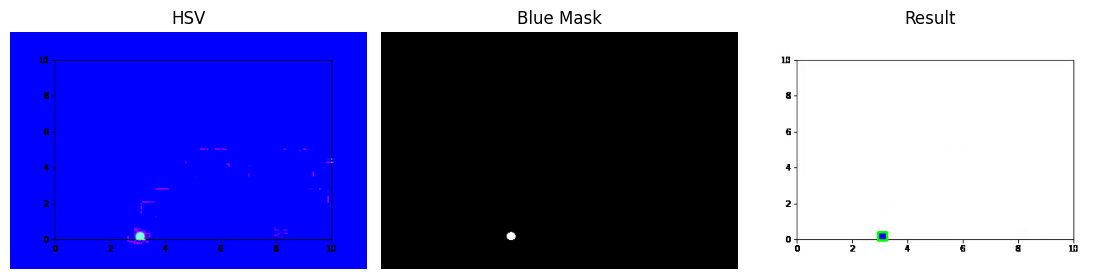

Collision at 11.40 seconds


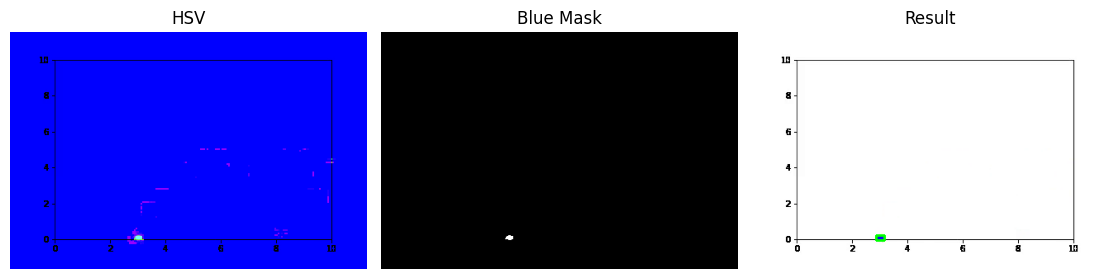

Collision at 11.43 seconds


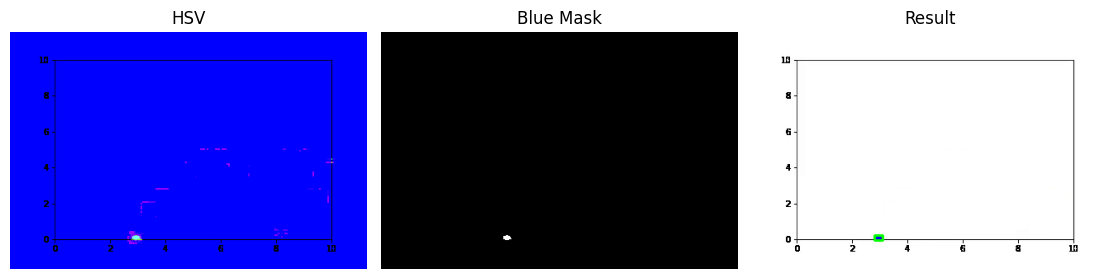

Collision at 11.45 seconds


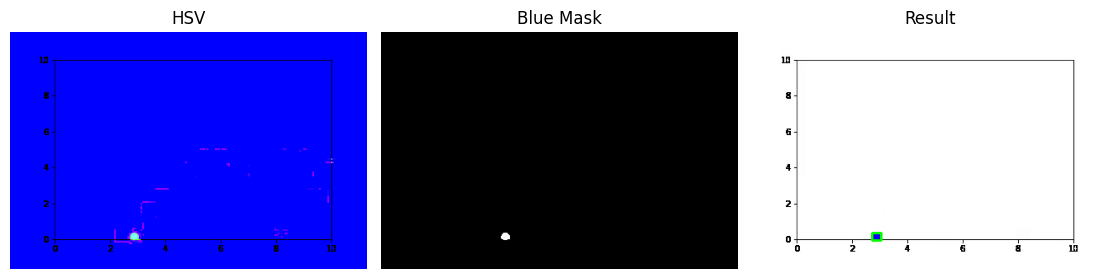

Collision at 12.40 seconds


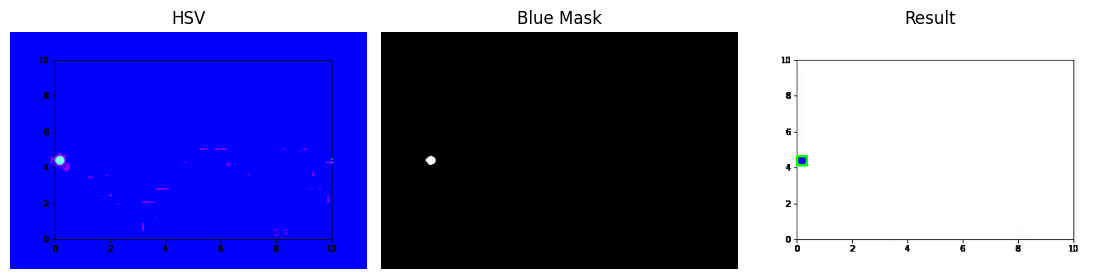

Collision at 12.42 seconds


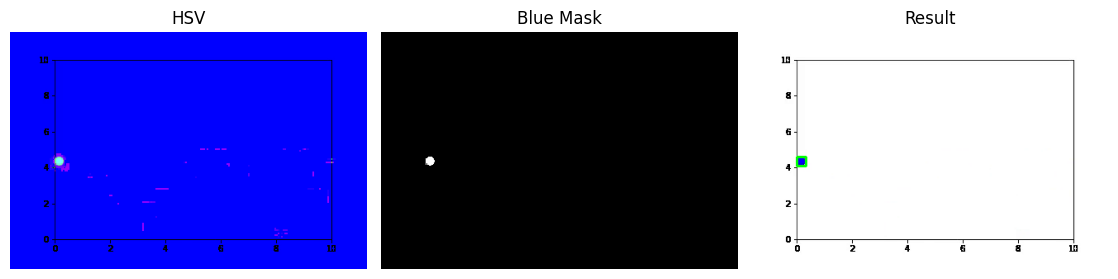

Collision at 12.43 seconds


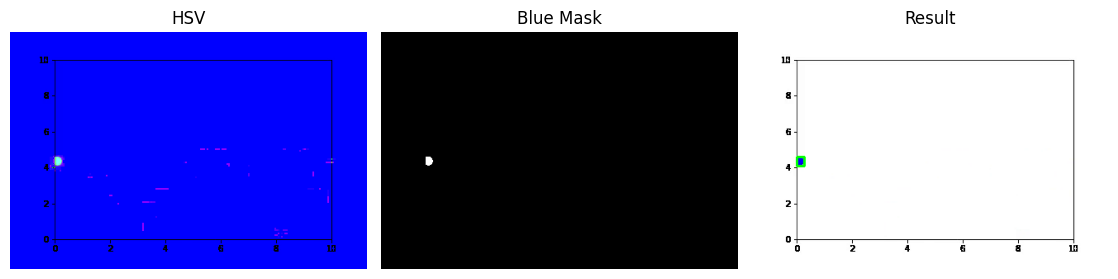

Collision at 12.45 seconds


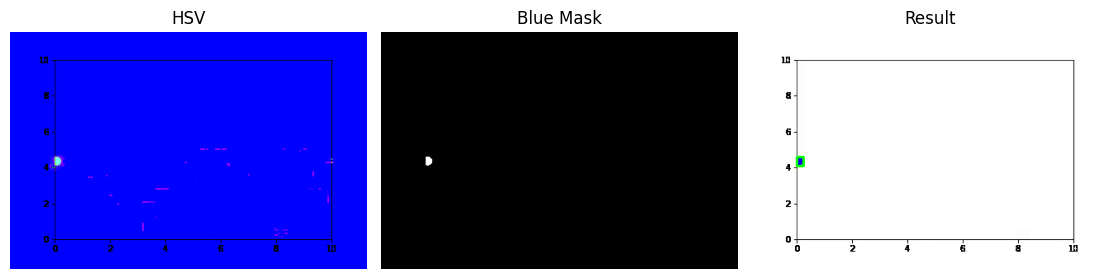

Collision at 12.47 seconds


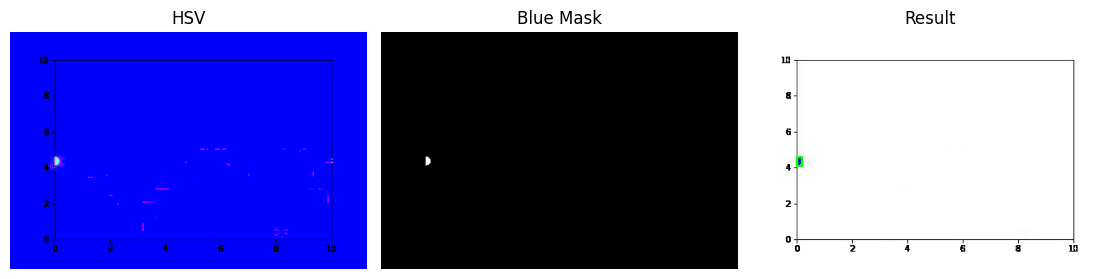

Collision at 12.48 seconds


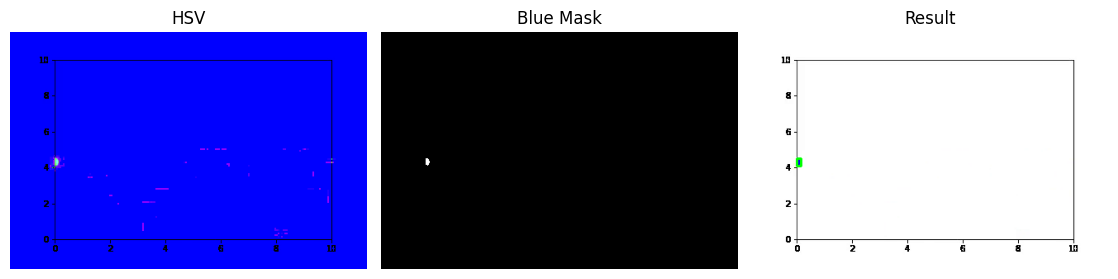

Collision at 12.50 seconds


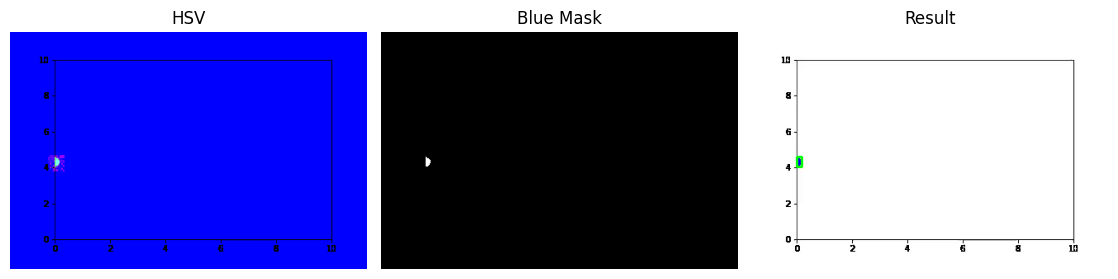

Collision at 12.52 seconds


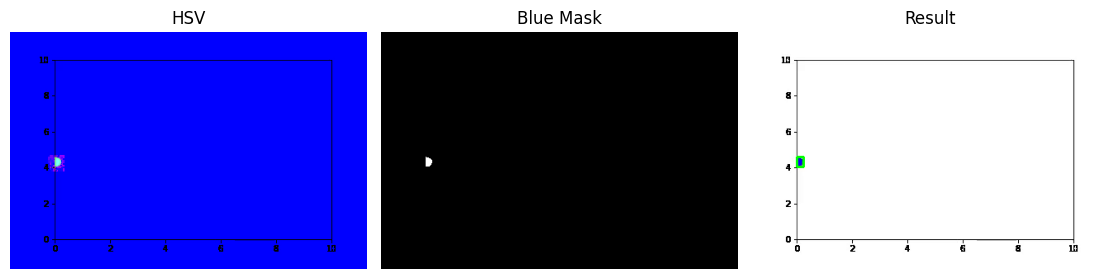

Collision at 12.53 seconds


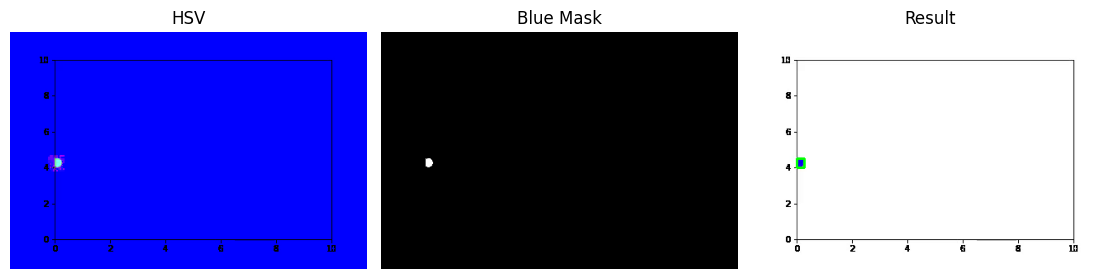

Collision at 12.55 seconds


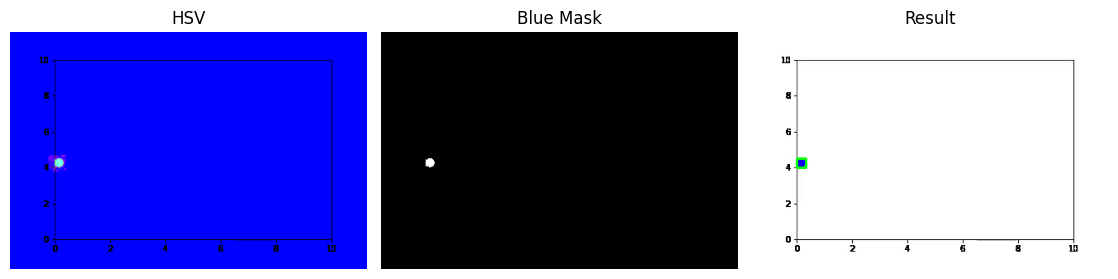

Collision at 12.57 seconds


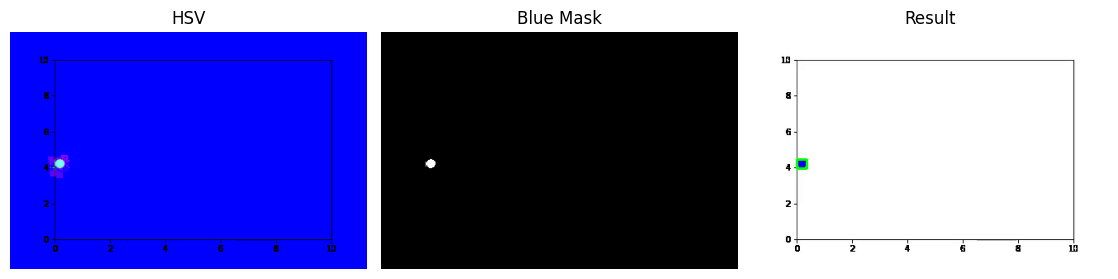

Collision at 13.30 seconds


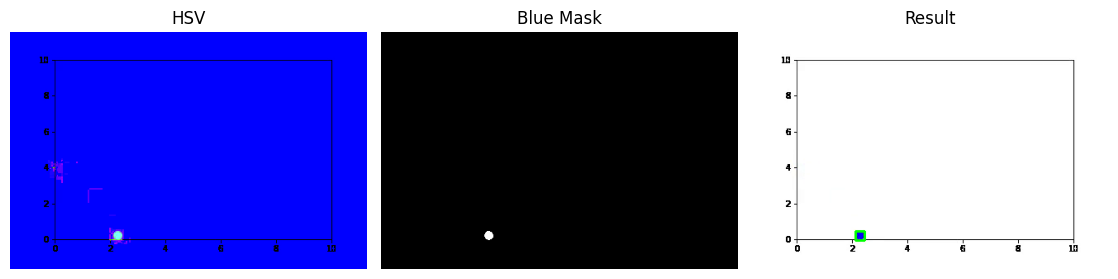

Collision at 13.32 seconds


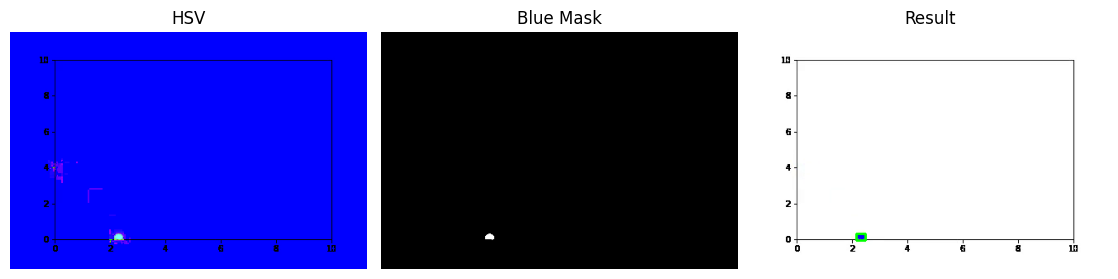

Collision at 13.33 seconds


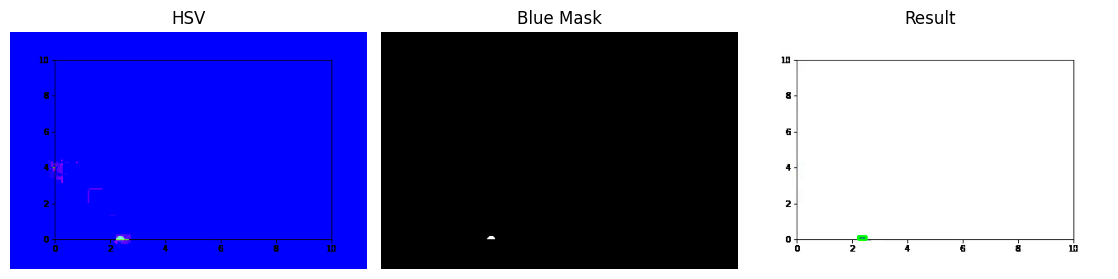

Collision at 13.35 seconds


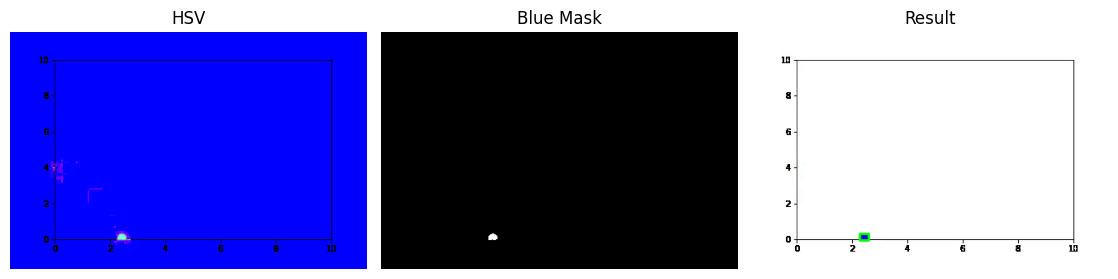

Collision at 13.37 seconds


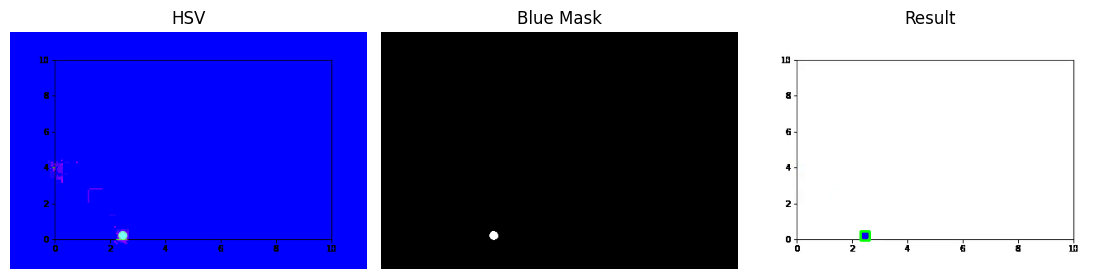

Collision at 15.18 seconds


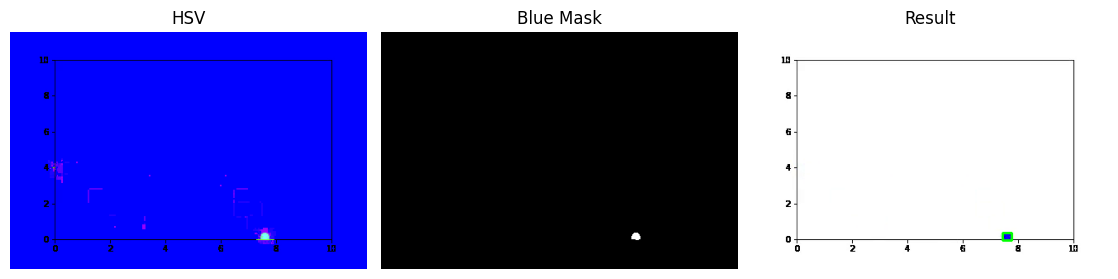

Collision at 15.20 seconds


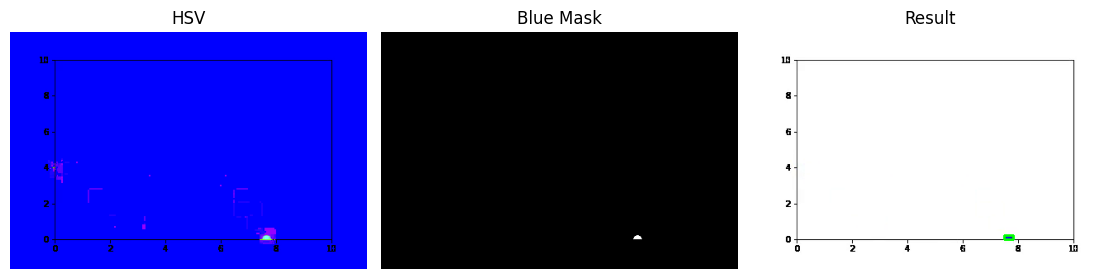

Collision at 15.23 seconds


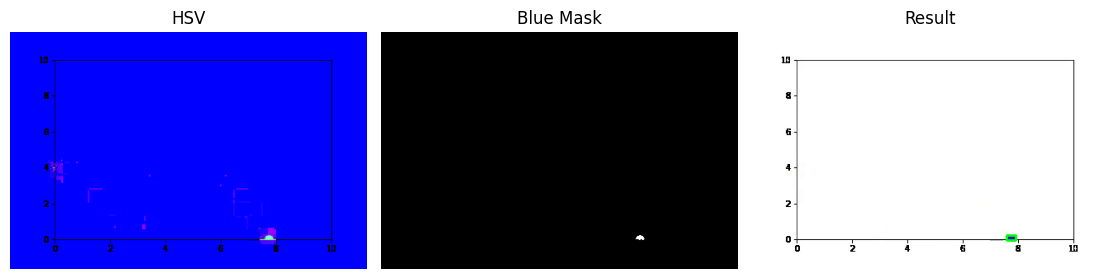

Collision at 15.25 seconds


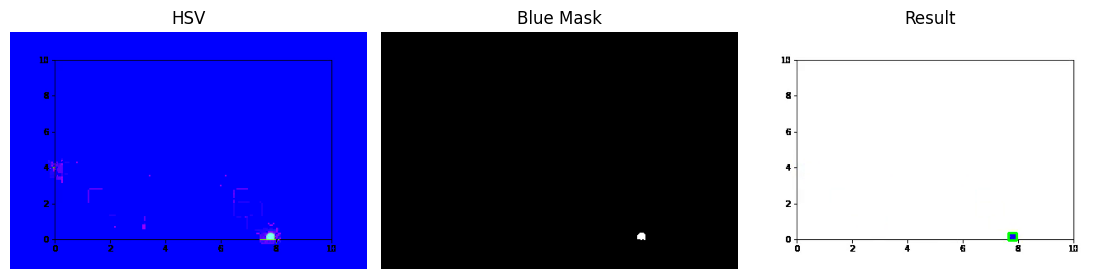

Collision at 15.27 seconds


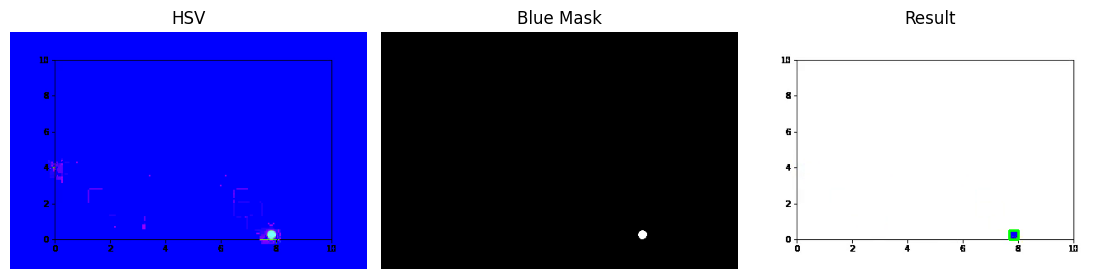

Collision at 15.98 seconds


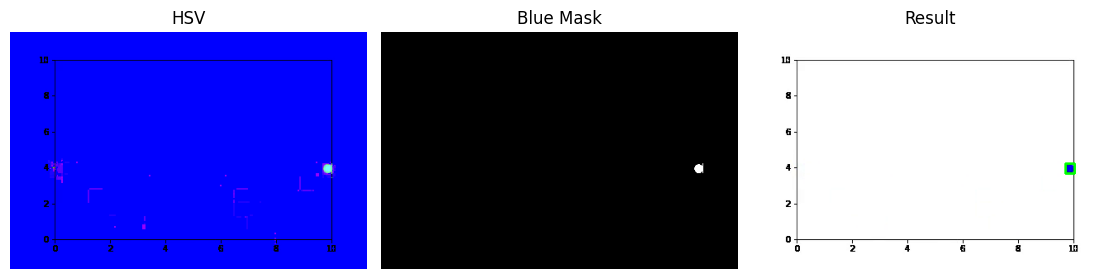

Collision at 16.00 seconds


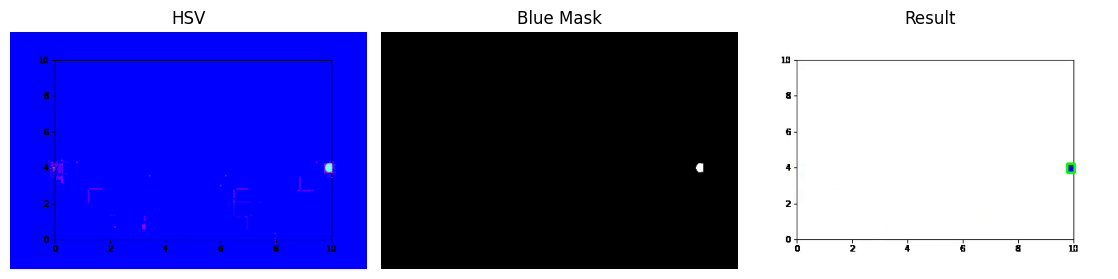

Collision at 16.02 seconds


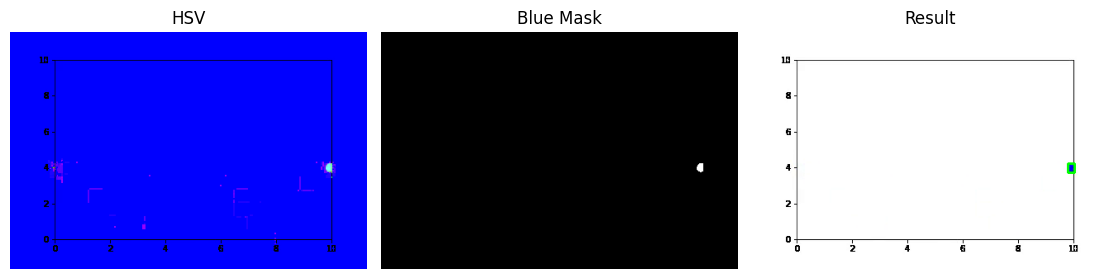

Collision at 16.03 seconds


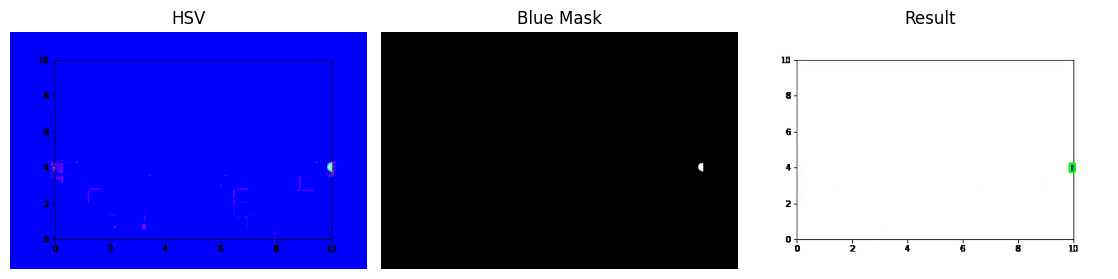

Collision at 16.05 seconds


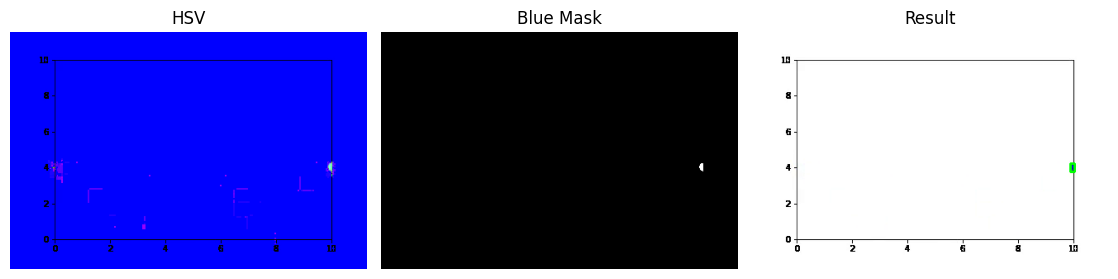

Collision at 16.07 seconds


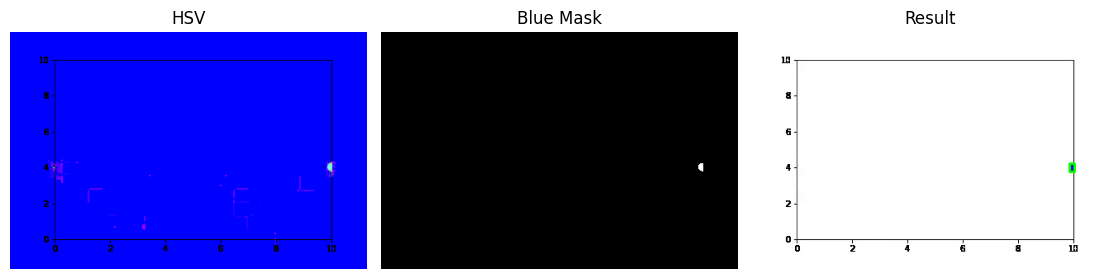

Collision at 16.08 seconds


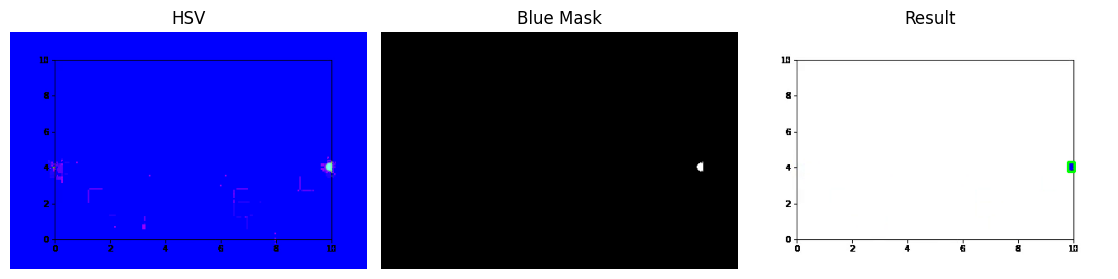

Collision at 16.10 seconds


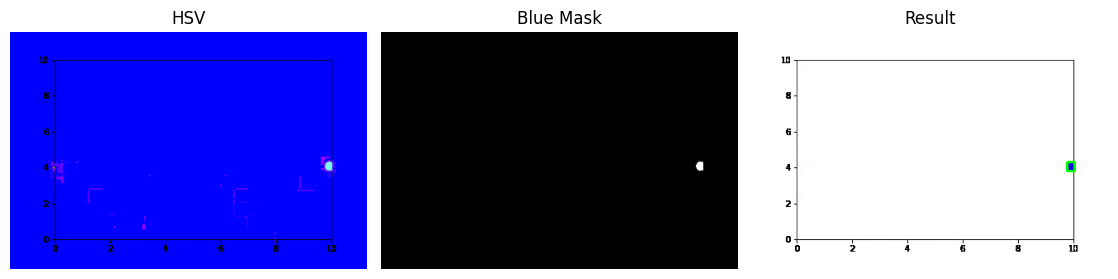

Collision at 16.12 seconds


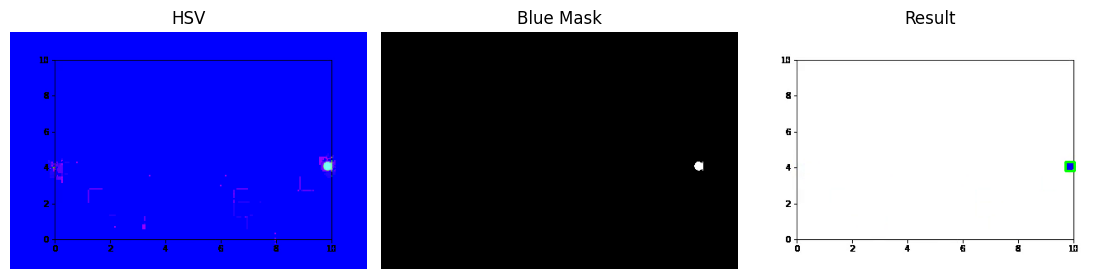

Collision at 17.03 seconds


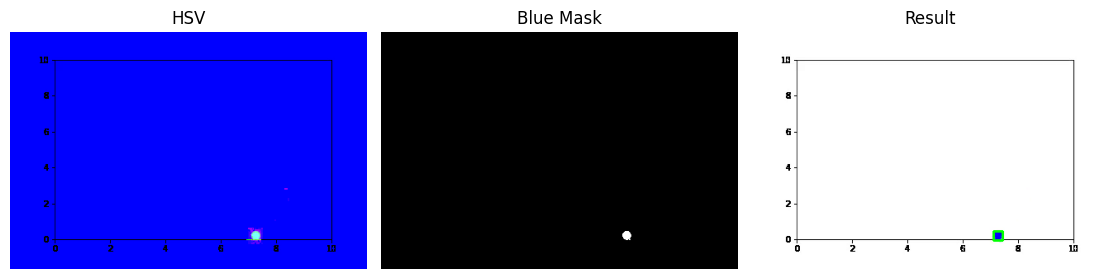

Collision at 17.05 seconds


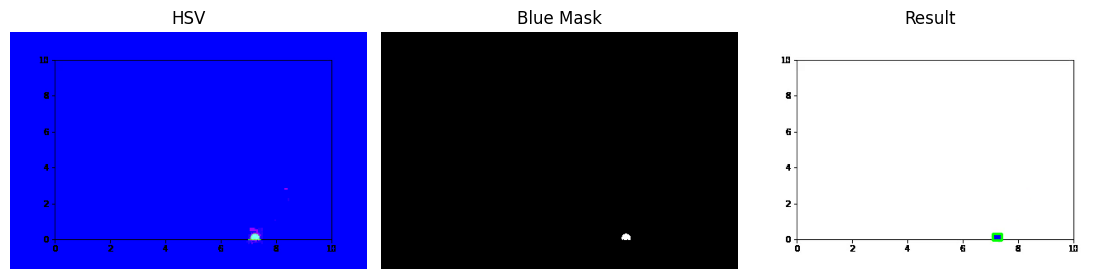

Collision at 17.07 seconds


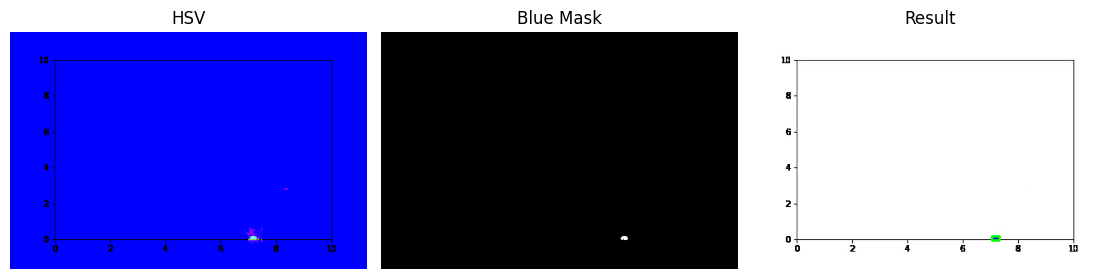

Collision at 17.08 seconds


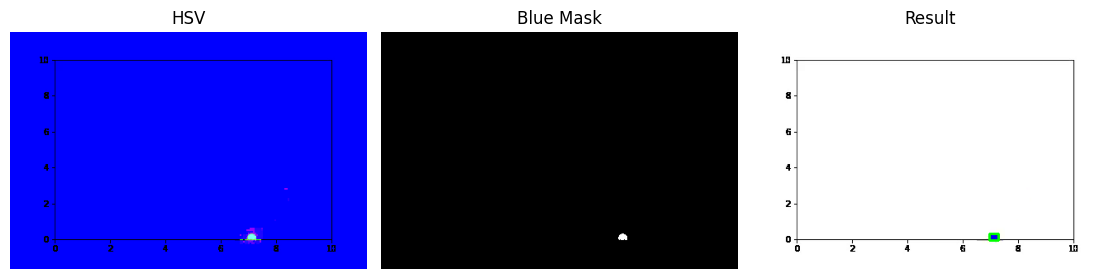

Collision at 17.10 seconds


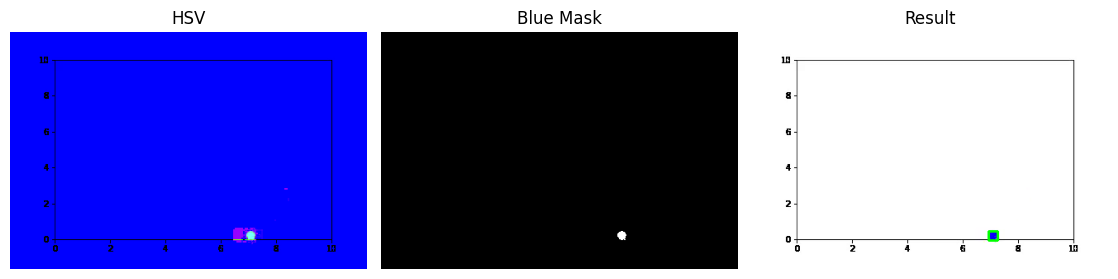

Collision at 18.83 seconds


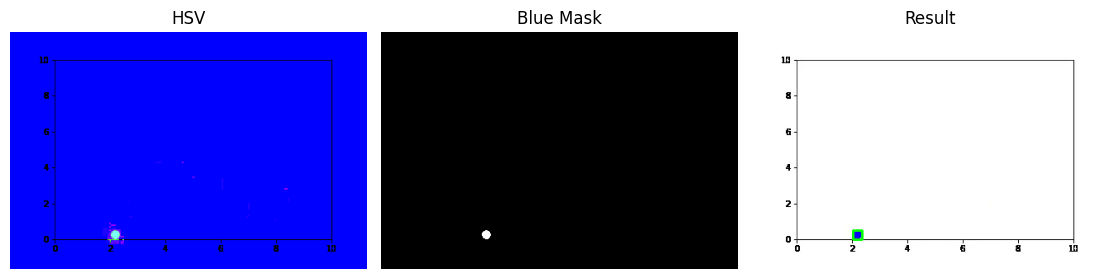

Collision at 18.85 seconds


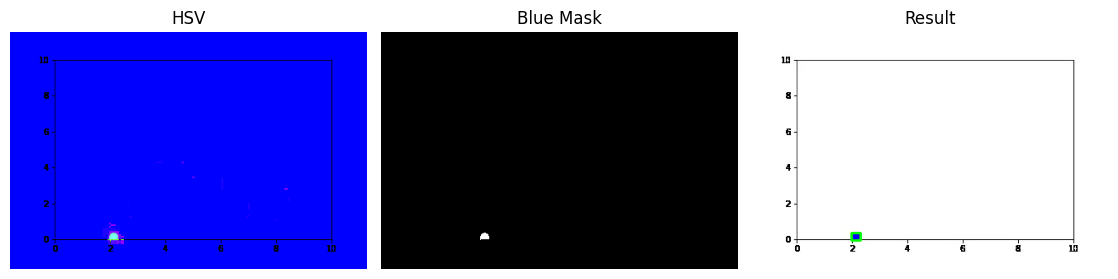

Collision at 18.87 seconds


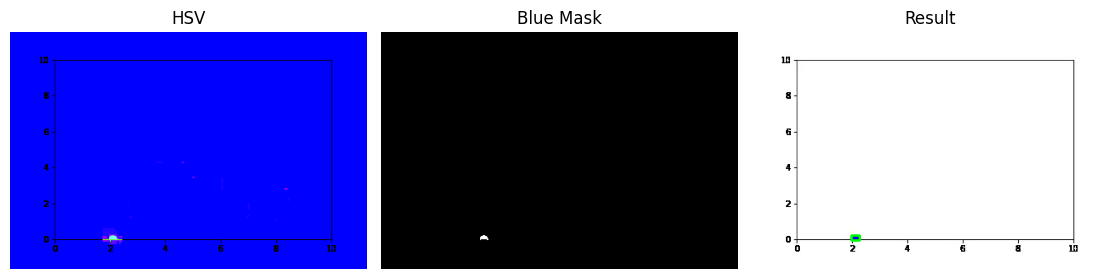

Collision at 18.88 seconds


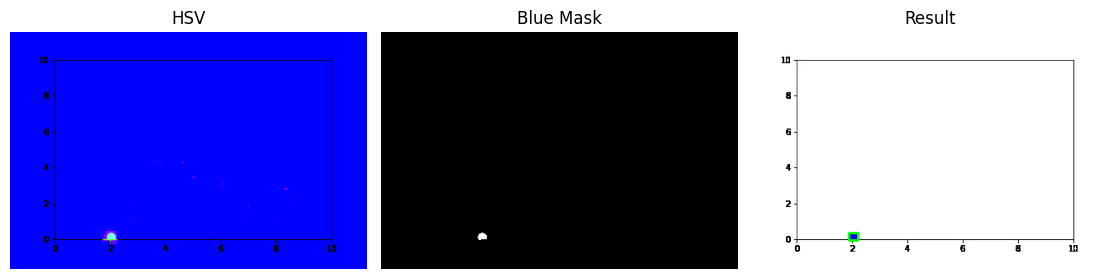

Collision at 18.90 seconds


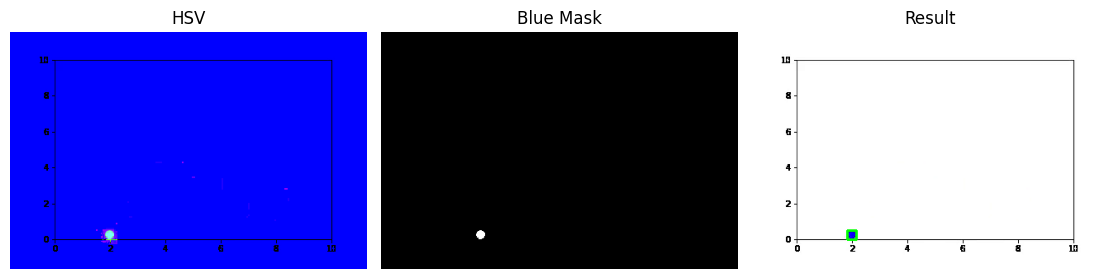

Collision at 19.53 seconds


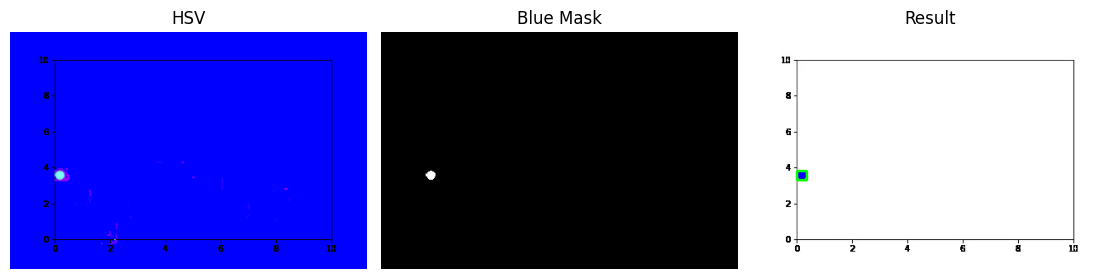

Collision at 19.55 seconds


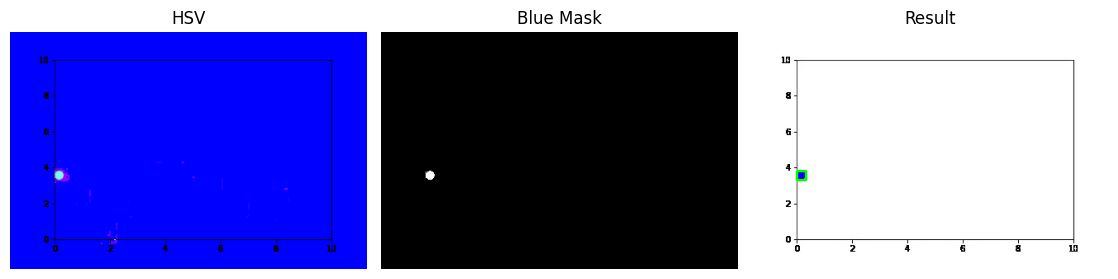

Collision at 19.57 seconds


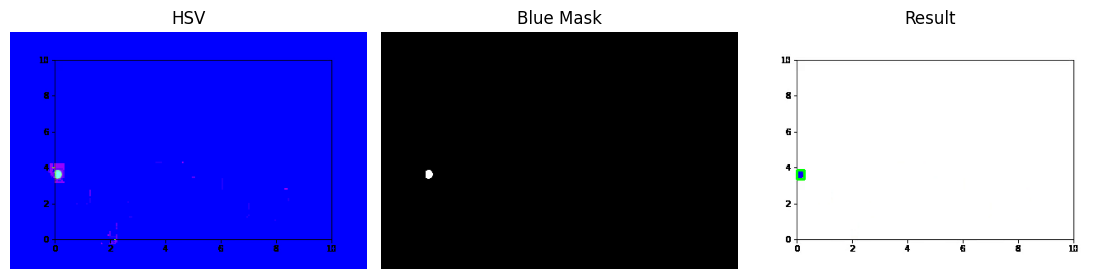

Collision at 19.58 seconds


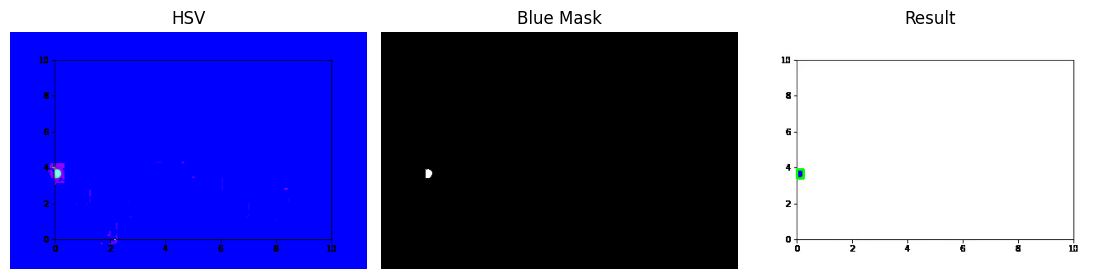

Collision at 19.60 seconds


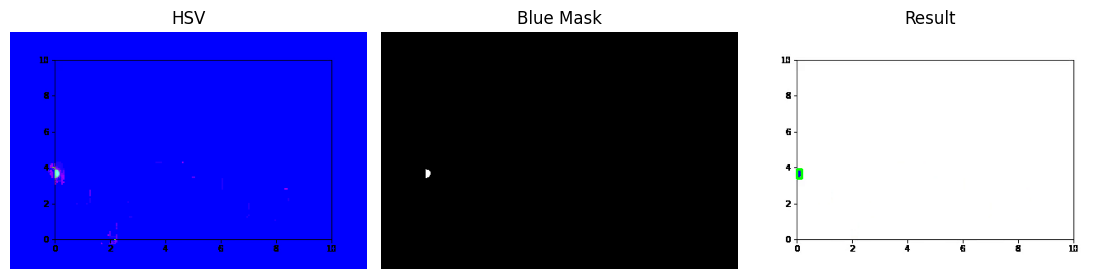

Collision at 19.62 seconds


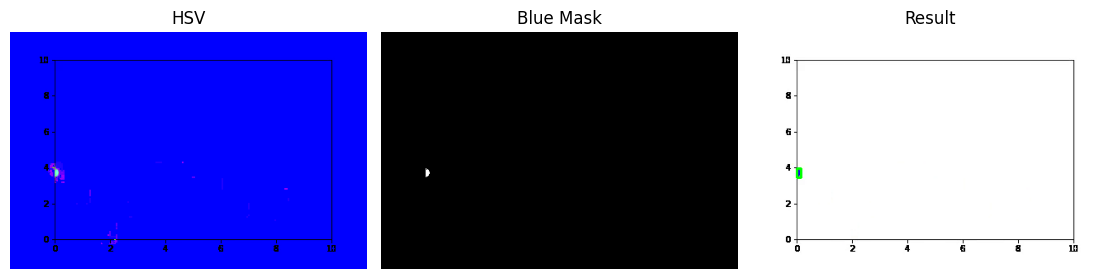

Collision at 19.63 seconds


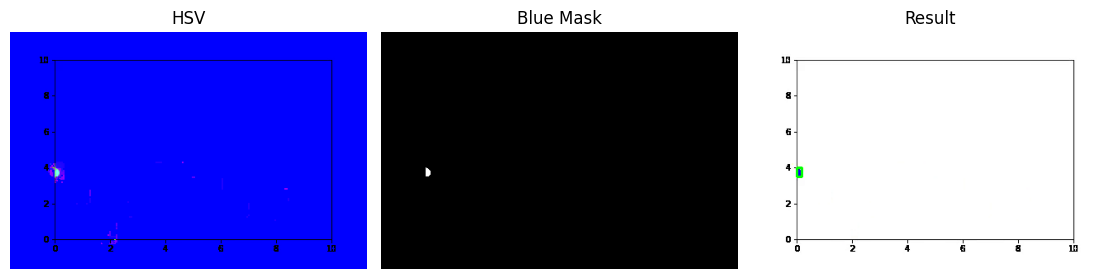

Collision at 19.65 seconds


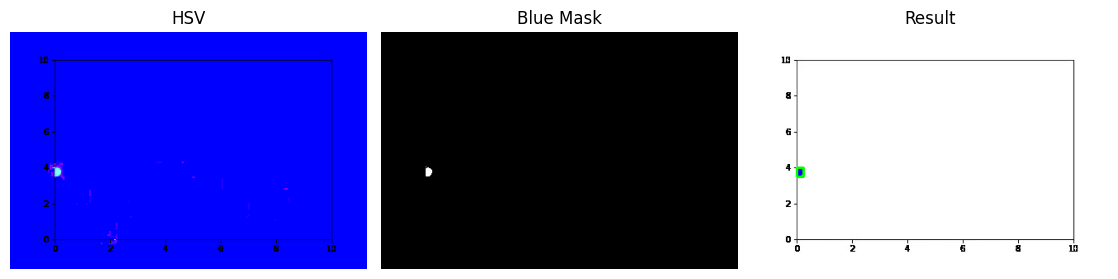

Collision at 19.67 seconds


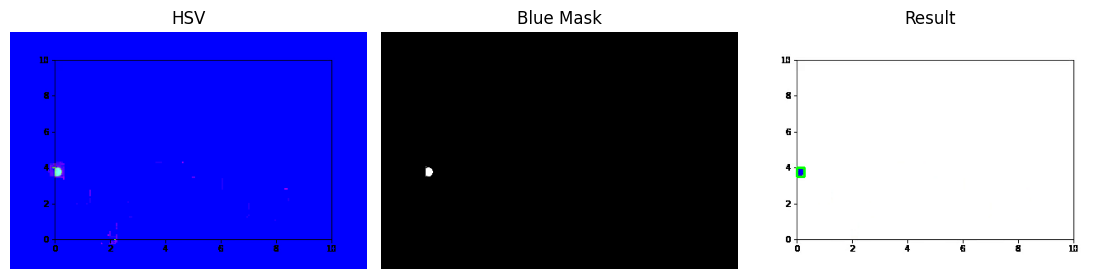

Collision at 19.68 seconds


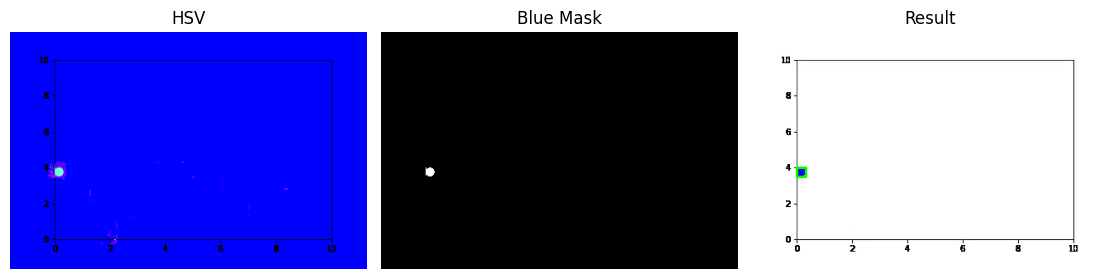

Collision at 19.70 seconds


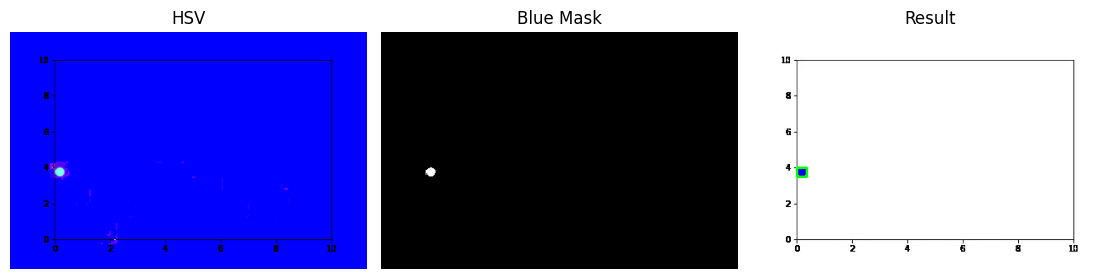

In [19]:
# Load the video
video = cv2.VideoCapture("/kaggle/input/search-for-a-match/dataset_Task2/video_only/video_only_ID_10.mp4")
fps = video.get(cv2.CAP_PROP_FPS)
frame_count = 0
collision_timestamps = []
while True:
    ret, frame = video.read()
    if not ret:
        break
    
    # Detect coordinate axes using Hough Line Transform
    lines = detect_coordinates(frame)
    # Convert to HSV and mask the blue ball
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
    # Find blue ball contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    collision_detected = False
    for contour in contours:
        if cv2.contourArea(contour) > 10:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            # Check collision with axes
            if (x <= lines[0] or 
                y <= lines[1] or 
                (x + w) >= lines[2] or 
                (y + h) >= lines[3]):
                timestamp = video.get(cv2.CAP_PROP_POS_MSEC) / 1000
                collision_timestamps.append(timestamp)
                print(f"Collision at {timestamp:.2f} seconds")
                collision_detected = True
    
    # Visualize every second (based on FPS)
    if collision_detected:
        plt.figure(figsize=(15, 4))
        plt.subplot(141), plt.title("HSV"), plt.imshow(hsv), plt.axis('off')
        plt.subplot(142), plt.title("Blue Mask"), plt.imshow(mask, cmap='gray'), plt.axis('off')
        plt.subplot(143), plt.title("Result"), plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)), plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    frame_count += 1

video.release()


Collision at 1.30 seconds


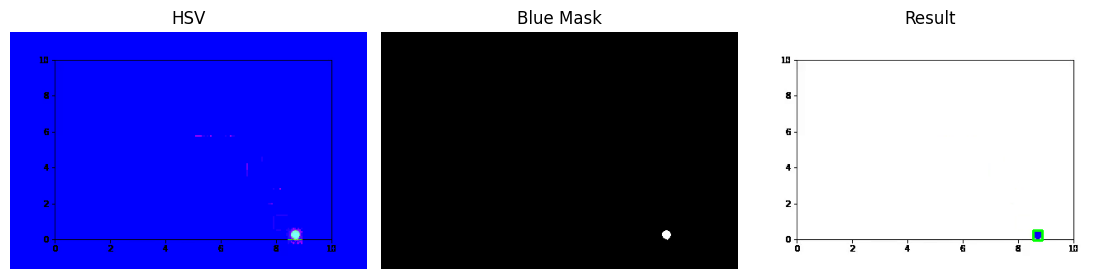

Collision at 1.72 seconds


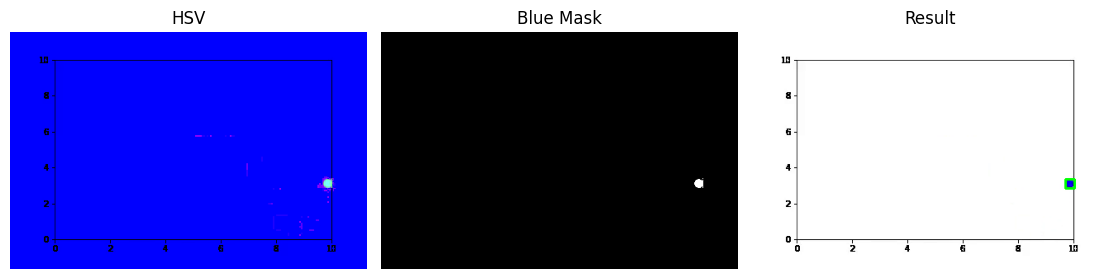

Collision at 3.38 seconds


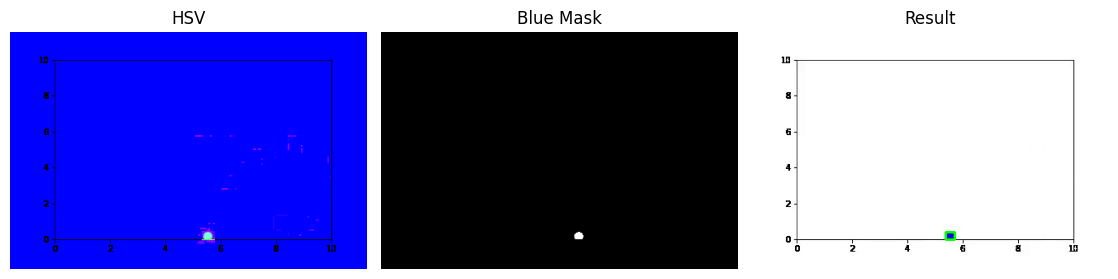

Collision at 5.27 seconds


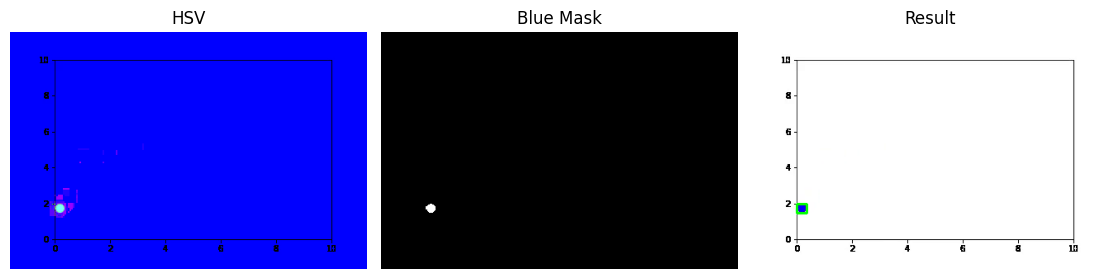

Collision at 7.45 seconds


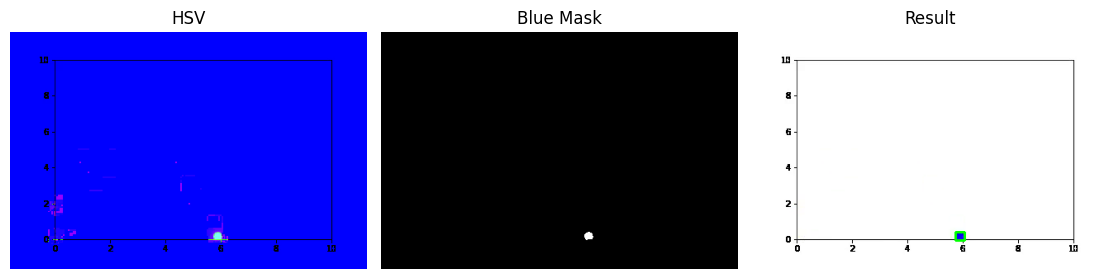

Collision at 8.85 seconds


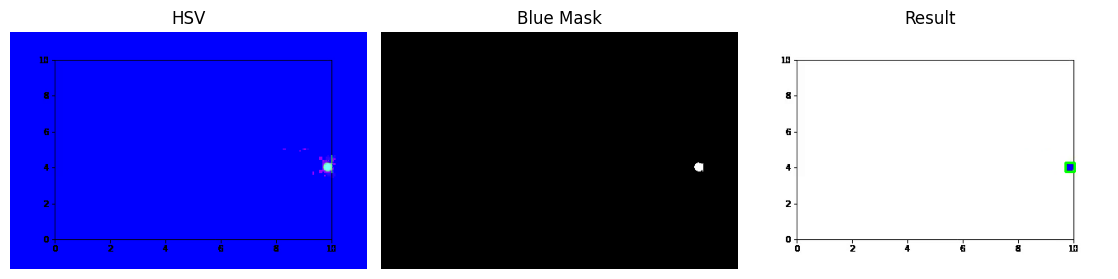

Collision at 9.43 seconds


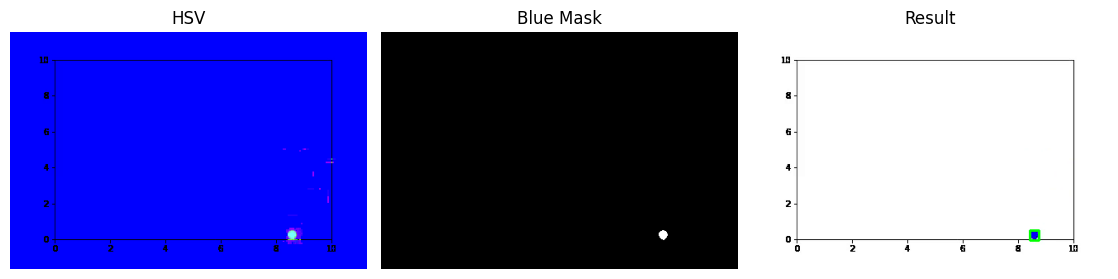

Collision at 11.38 seconds


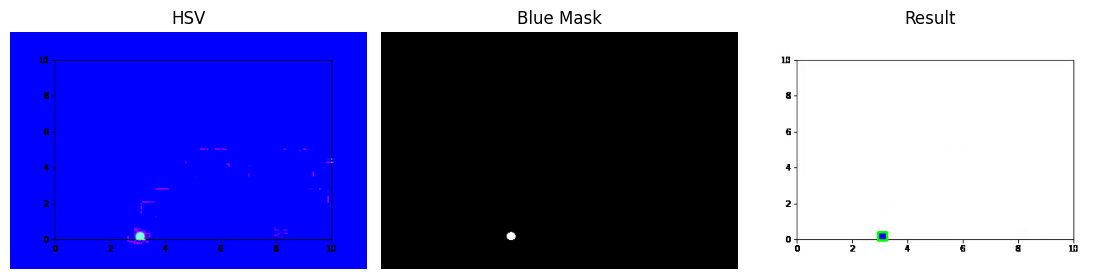

Collision at 12.40 seconds


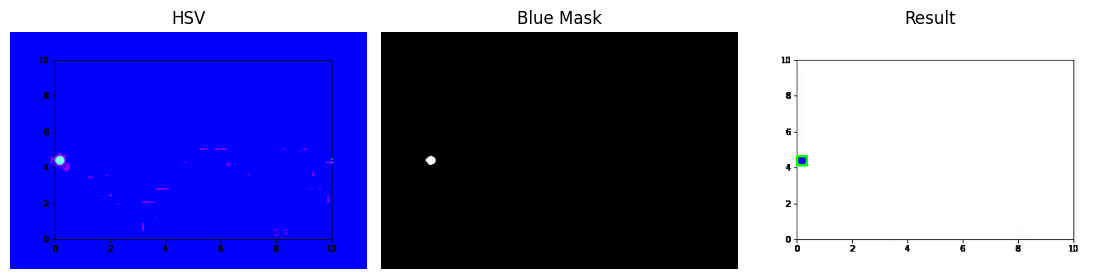

Collision at 13.30 seconds


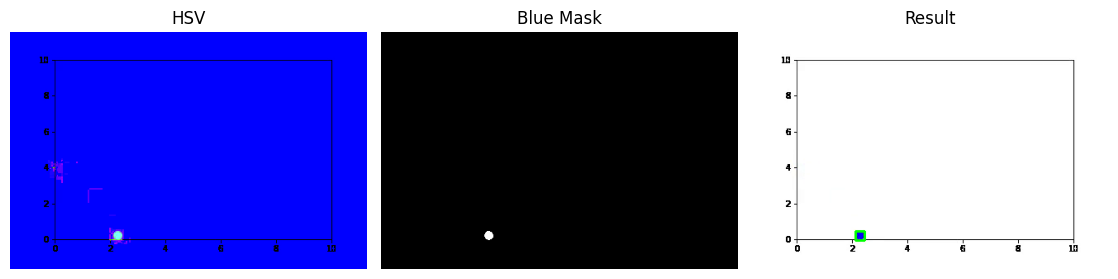

Collision at 15.18 seconds


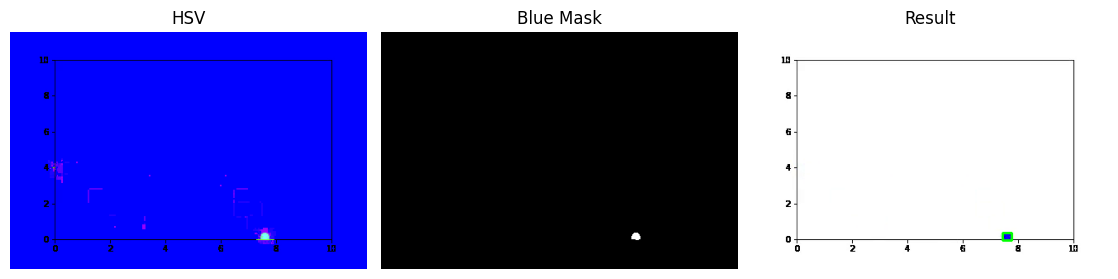

Collision at 15.98 seconds


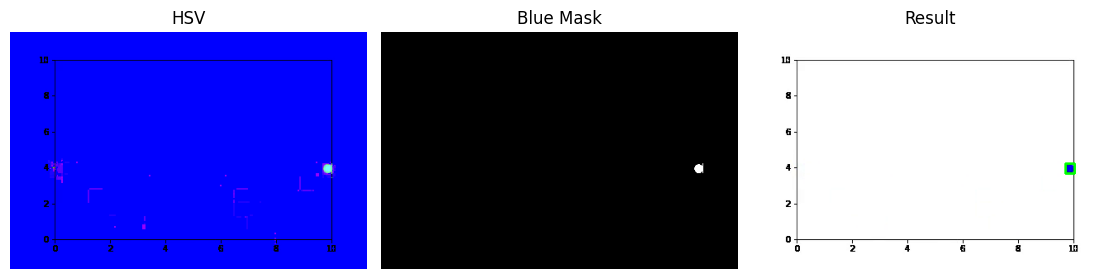

Collision at 17.03 seconds


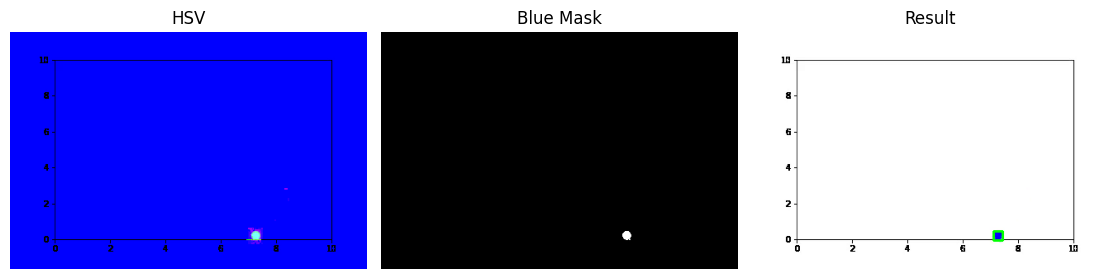

Collision at 18.83 seconds


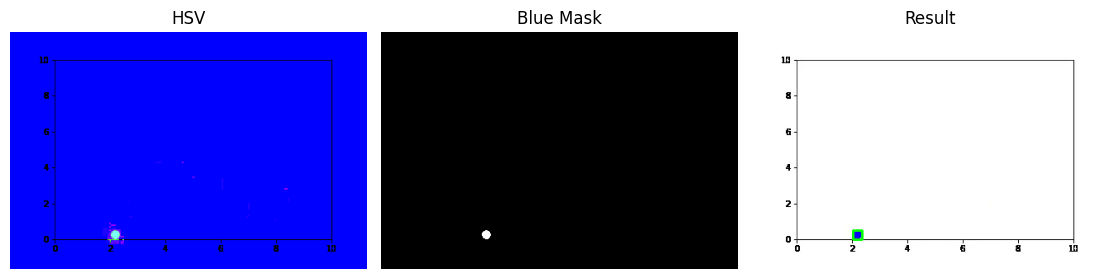

Collision at 19.53 seconds


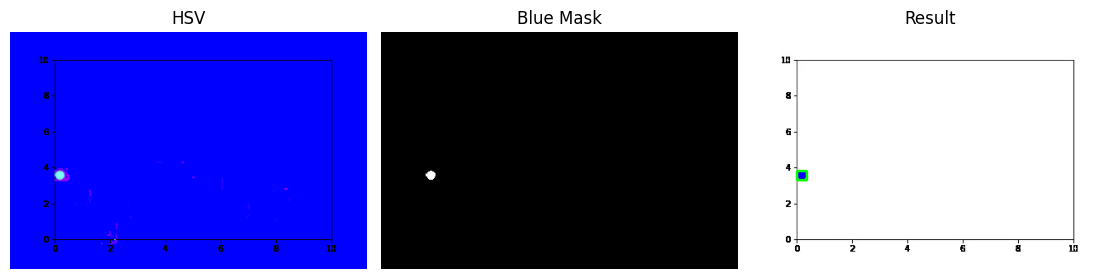

In [20]:
# Load the video
video = cv2.VideoCapture("/kaggle/input/search-for-a-match/dataset_Task2/video_only/video_only_ID_10.mp4")
fps = video.get(cv2.CAP_PROP_FPS)
frame_count = 0
collision_timestamps = []
last_collision_time = -1  # Initialize to an invalid time
collision_threshold = 0.25  # Minimum time (in seconds) between consecutive collisions

while True:
    ret, frame = video.read()
    if not ret:
        break
    
    # Detect coordinate axes using Hough Line Transform
    lines = detect_coordinates(frame)
    
    # Convert to HSV and mask the blue ball
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([140, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
    # Find blue ball contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    collision_detected = False
    
    for contour in contours:
        if cv2.contourArea(contour) > 10:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            # Check collision with axes
            if (x <= lines[0] or 
                y <= lines[1] or 
                (x + w) >= lines[2] or 
                (y + h) >= lines[3]):
                timestamp = video.get(cv2.CAP_PROP_POS_MSEC) / 1000
                
                # Check if this collision is sufficiently far from the last recorded one
                if last_collision_time == -1 or (timestamp - last_collision_time > collision_threshold):
                    collision_timestamps.append(timestamp)
                    print(f"Collision at {timestamp:.2f} seconds")
                    last_collision_time = timestamp  # Update the last collision time
                    collision_detected = True
    
    # Visualize every second (based on FPS)
    if collision_detected:
        plt.figure(figsize=(15, 4))
        plt.subplot(141), plt.title("HSV"), plt.imshow(hsv), plt.axis('off')
        plt.subplot(142), plt.title("Blue Mask"), plt.imshow(mask, cmap='gray'), plt.axis('off')
        plt.subplot(143), plt.title("Result"), plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)), plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    frame_count += 1

video.release()


In [21]:
def get_collision_times(video_path):
    # Load the video
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    #frame_count = 0
    collision_timestamps = []
    last_collision_time = -1  # Initialize to an invalid time
    collision_threshold = 0.25  # Minimum time (in seconds) between consecutive collisions

    while True:
        ret, frame = video.read()
        if not ret:
            break
    
        # Detect coordinate axes using Hough Line Transform
        lines = detect_coordinates(frame)
    
        # Convert to HSV and mask the blue ball
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        lower_blue = np.array([100, 150, 50])
        upper_blue = np.array([140, 255, 255])
        mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
        # Find blue ball contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        collision_detected = False
    
        for contour in contours:
            if cv2.contourArea(contour) > 10:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
                # Check collision with axes
                if (x <= lines[0] or 
                    y <= lines[1] or 
                    (x + w) >= lines[2] or 
                    (y + h) >= lines[3]):
                    timestamp = video.get(cv2.CAP_PROP_POS_MSEC) / 1000
                
                    # Check if this collision is sufficiently far from the last recorded one
                    if last_collision_time == -1 or (timestamp - last_collision_time > collision_threshold):
                        collision_timestamps.append(timestamp)
                        #print(f"Collision at {timestamp:.2f} seconds")
                        last_collision_time = timestamp  # Update the last collision time
                        collision_detected = True
                    
    video.release()
    return np.array(collision_timestamps)

In [22]:
times = get_collision_times("/kaggle/input/search-for-a-match/dataset_Task2/video_only/video_only_ID_1.mp4")
print(times)

[ 0.31666667  0.98333333  1.48333333  2.31666667  2.98333333  3.65
  4.31666667  4.98333333  5.65        6.31666667  6.98333333  7.65
  7.91666667  8.31666667  8.98333333  9.65        9.95       10.31666667
 10.98333333 11.65       11.98333333 12.31666667 12.98333333 13.65
 13.98333333 14.31666667 14.98333333 15.65       15.95       16.31666667
 16.98333333 17.65       17.91666667 18.31666667 18.98333333 19.65      ]


In [23]:
impulse_times = get_impulse_times("/kaggle/input/search-for-a-match/dataset_Task2/audio_only/audio_only_ID_24.wav")
collision_times = get_collision_times("/kaggle/input/search-for-a-match/dataset_Task2/video_only/video_only_ID_17.mp4")

In [24]:
impulse_times

array([ 0.        ,  1.20649652,  3.45707657,  3.64269142,  6.07888631,
        7.16937355,  8.51508121, 10.83526682, 13.36426914, 14.47795824,
       15.80046404, 18.23665893])

In [25]:
collision_times

array([ 1.61666667,  3.9       ,  4.95      ,  6.1       ,  8.3       ,
       10.43333333, 11.65      , 12.56666667, 14.63333333, 15.01666667,
       16.7       , 18.35      , 18.7       ])

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

collision_times_scaled = scaler.fit_transform(np.array(collision_times).reshape(-1, 1)).flatten()
impulse_times_scaled = scaler.fit_transform(np.array(impulse_times).reshape(-1, 1)).flatten()
# Normalize both lists
collision_times_scaled = np.array(collision_times_scaled).reshape(-1, 1)
impulse_times_scaled = np.array(impulse_times_scaled).reshape(-1, 1)

distance, _ = fastdtw(collision_times_scaled, impulse_times_scaled, dist=euclidean)
print("Normalized DTW Distance:", distance)

Normalized DTW Distance: 0.3289505368336125


In [27]:
def dtw_distance(video_times,audio_times):
    scaler = MinMaxScaler()

    collision_times_scaled = scaler.fit_transform(np.array(video_times).reshape(-1, 1)).flatten()
    impulse_times_scaled = scaler.fit_transform(np.array(audio_times).reshape(-1, 1)).flatten()
    # Normalize both lists
    collision_times_scaled = np.array(collision_times_scaled).reshape(-1, 1)
    impulse_times_scaled = np.array(impulse_times_scaled).reshape(-1, 1)

    distance, _ = fastdtw(collision_times_scaled, impulse_times_scaled, dist=euclidean)
    return distance

In [28]:
num_files = 45
cost_matrix = np.zeros((num_files, num_files))

video_paths = [f"/kaggle/input/search-for-a-match/dataset_Task2/video_only/video_only_ID_{i}.mp4" for i in range(1,46)]
audio_paths = [f"/kaggle/input/search-for-a-match/dataset_Task2/audio_only/audio_only_ID_{i}.wav" for i in range(1,46)]

for i, video in enumerate(video_paths):
    video_times = get_collision_times(video)
    
    for j, audio in enumerate(audio_paths):
        audio_times = get_impulse_times(audio)
        cost_matrix[i, j] = dtw_distance(np.array(video_times), np.array(audio_times))


In [29]:
print(cost_matrix)

[[1.0759476  0.45495614 0.85187471 ... 0.30642483 0.80965679 0.269677  ]
 [0.69253287 0.35062774 0.50917091 ... 0.36543877 0.44387396 0.45460799]
 [0.3244694  0.5405121  0.32355963 ... 0.66559072 0.3374013  0.93054704]
 ...
 [0.41360294 0.42705675 0.37346588 ... 0.60857448 0.36059618 0.85166109]
 [0.97317414 0.49236152 0.85710716 ... 0.31649492 0.79834214 0.30265525]
 [0.84813802 0.4723654  0.63743923 ... 0.3571713  0.67008843 0.39882787]]


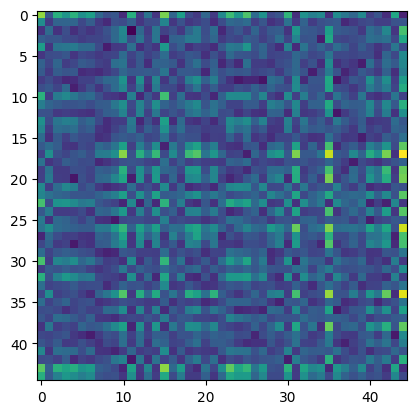

In [31]:
plt.imshow(cost_matrix)

In [32]:
cost_matrix -= cost_matrix.min(axis=1, keepdims=True)

In [33]:
# Hungarian Algorithm
video_indices, audio_indices = linear_sum_assignment(cost_matrix)

In [34]:
print(f"video_indices:{video_indices}")

video_indices:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


In [35]:
print(f"audio_indices:{audio_indices}")

audio_indices:[44 21 11 34  8 41 39  5 24 13 10 27 36 12 28  1 15 25 38  2  4 18 32 42
 17 40 23 22 43 20 31  7 14 33  6 29  3  9  0 26 37 16 30 35 19]


In [ ]:
# Create filename pairs in the exact format from search results
mapping = []
for vid_idx, aud_idx in zip(video_indices, audio_indices):
    mapping.append({
        'AUDIO': f'audio_only_ID_{aud_idx+1}.wav',
        'VIDEO': f'video_only_ID_{vid_idx+1}.mp4'
    })

# Create DataFrame with identical structure to search results
mapping_df = pd.DataFrame(mapping)

# Save to CSV with exact formatting
mapping_df.to_csv('audio_video_mapping.csv', index=False)

In [39]:
print(mapping_df.head())

                  AUDIO                VIDEO
0  audio_only_ID_45.wav  video_only_ID_1.mp4
1  audio_only_ID_22.wav  video_only_ID_2.mp4
2  audio_only_ID_12.wav  video_only_ID_3.mp4
3  audio_only_ID_35.wav  video_only_ID_4.mp4
4   audio_only_ID_9.wav  video_only_ID_5.mp4


In [ ]:
def combine_video_audio(video_path, audio_path, output_path):
    # Load the video and audio files
    video_clip = VideoFileClip(video_path)
    audio_clip = AudioFileClip(audio_path)

    # Set the audio of the video clip
    final_clip = video_clip.set_audio(audio_clip)

    # Write the final output to a file
    final_clip.write_videofile(output_path, codec="libx264", audio_codec="aac")

# Example usage
video_file = "/kaggle/input/search-for-a-match/dataset_Task2/video_only/video_only_ID_17.mp4"  # Path to your video file
audio_file = "/kaggle/input/search-for-a-match/dataset_Task2/audio_only/audio_only_ID_25.wav"  # Path to your audio file
output_file = "sample_combined_output_17_25.mp4"  # Path to save the combined output

combine_video_audio(video_file, audio_file, output_file)
